# <font color=black> Gramener Case Study </font>

This company is the largest online loan marketplace, facilitating personal loans, business loans, and financing of medical procedures.<br>
Borrowers can easily access lower interest rate loans through a fast online interface. 
Like most other lending companies, lending loans to ‘risky’ applicants is the largest source of financial loss (called credit loss).<br>
The credit loss is the amount of money lost by the lender when the borrower refuses to pay or runs away with the money owed. In other words, borrowers who default cause the largest amount of loss to the lenders.<br>
In this case, the customers labelled as 'charged-off' are the 'defaulters'.<br>
If one is able to identify these risky loan applicants, then such loans can be reduced thereby cutting down the amount of credit loss.<br>
Identification of such applicants using EDA is the aim of this case study.
<br>
In other words, the company wants to understand the driving factors (or driver variables) behind loan default, i.e. the variables which are strong indicators of default.
<br>
The company can utilise this knowledge for its portfolio and risk assessment.

In [1]:
# Import the required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
sns.set(style='whitegrid', rc={"grid.linewidth": 0.3})
pd.set_option('display.max_columns', None) # To view all the columns of the dataset

In [2]:
# Generic function to create labels over bar plot
def create_label(ax,type_of_label):
    rects = ax.patches
    
    # For each bar: Place a label
    for rect in rects:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
    
        # Number of points between bar and label. Change to your liking.
        space = 0
        # Vertical alignment for positive values
        va = 'bottom'
    
        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'
    
        # Use Y value as label and format number with two decimal places
        if type_of_label == 'integer':
            y_value = int(y_value)
            label = "{}".format(y_value)
        else:
            label = "{:.2f}".format(y_value)
    
        # Create annotation
        plt.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.

# Function to modify bar width of seaborn plot
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

## 1. Data Understanding

In [3]:
# Import the loan data
loan_data = pd.read_csv('loan.csv',low_memory=False)
loan_data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0,Jan-85,1,NaN,NaN,3,0,13648,83.70%,9,f,0.00,0.00,5863.155187,5833.84,5000.00,863.16,0.00,0.00,0.00,Jan-15,171.62,NaN,May-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0,Apr-99,5,NaN,NaN,3,0,1687,9.40%,4,f,0.00,0.00,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,NaN,Sep-13,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,real estate business,606xx,IL,8.72,0,Nov-01,2,NaN,NaN,2,0,2956,98.50%,10,f,0.00,0.00,3005.666844,3005.67,2400.00,605.67,0.00,0.00,0.00,Jun-14,649.91,NaN,May-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0,Feb-96,1,35.0,NaN,10,0,5598,21%,37,f,0.00,0.00,12231.890000,12231.89,10000.00,2214.92,16.97,0.00,0.00,Jan-15,357.48,NaN,Apr-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

** We have imported the loan_dataset. However, there are numerous non-essential arrtibutes[columns] with predominantly NA or 0 values. 
Let us understand the structure of the attributes in the loan_dataset. From here we will assess the requirements for data preparation and manipulation stage. **

In [4]:
# Check for the dataset columns and datatypes
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB


In [5]:
# Check for statistical information
loan_data.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
count,3.971700e+04,3.971700e+04,39717.000000,39717.000000,39717.000000,39717.000000,3.971700e+04,39717.000000,39717.000000,39717.000000,14035.000000,2786.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39661.0,0.0,39717.0,0.0,0.0,0.0,39717.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39661.0,39717.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39020.000000,39678.0,0.0,0.0,0.0,0.0
mean,6.831319e+05,8.504636e+05,11219.443815,10947.713196,10397.448868,324.561922,6.896893e+04,13.315130,0.146512,0.869200,35.900962,69.698134,9.294408,0.055065,13382.528086,22.088828,51.227887,50.989768,12153.596544,11567.149118,9793.348813,2263.663172,1.363015,95.221624,12.406112,2678.826162,0.0,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.043260,0.0,NaN,NaN,NaN,NaN
std,2.106941e+05,2.656783e+05,7456.670694,7187.238670,7128.450439,208.874874,6.379377e+04,6.678594,0.491812,1.070219,22.020060,43.822529,4.400282,0.237200,15885.016641,11.401709,375.172839,373.824457,9042.040766,8942.672613,7065.522127,2608.111964,7.289979,688.744771,148.671593,4447.136012,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.204324,0.0,NaN,NaN,NaN,NaN
min,5.473400e+04,7.069900e+04,500.000000,500.000000,0.000000,15.690000,4.000000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,NaN,NaN,NaN,NaN
25%,5.162210e+05,6.667800e+05,5500.000000,5400.000000,5000.000000,167.020000,4.040400e+04,8.170000,0.000000,0.000000,18.000000,22.000000,6.000000,0.000000,3703.000000,13.000000,0.000000,0.000000,5576.930000,5112.310000,4600.000000,662.180000,0.000000,0.000000,0.000000,218.680000,0.0,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

It can be seen from the above result that a lot of columns are having NaN values as well as values such as 0. We need to drop these columns during data cleansing. Also for few columns like 'installment','delinq_2yrs' etc. there are outliers since there is a noticeable gap between 75% values and max value. We will analyse the outliers later during univariate analysis.

In [6]:
loan_data.shape

(39717, 111)

In [7]:
# summing up the missing values (column-wise)
loan_data.isnull().sum()

id                                    0
member_id                             0
loan_amnt                             0
funded_amnt                           0
funded_amnt_inv                       0
term                                  0
int_rate                              0
installment                           0
grade                                 0
sub_grade                             0
emp_title                          2459
emp_length                         1075
home_ownership                        0
annual_inc                            0
verification_status                   0
issue_d                               0
loan_status                           0
pymnt_plan                            0
url                                   0
desc                              12940
purpose                               0
title                                11
zip_code                              0
addr_state                            0
dti                                   0


In [8]:
# Percentage of missing values column-wise
round(loan_data.isnull().sum()/len(loan_data.index)*100,2)

id                                  0.00
member_id                           0.00
loan_amnt                           0.00
funded_amnt                         0.00
funded_amnt_inv                     0.00
term                                0.00
int_rate                            0.00
installment                         0.00
grade                               0.00
sub_grade                           0.00
emp_title                           6.19
emp_length                          2.71
home_ownership                      0.00
annual_inc                          0.00
verification_status                 0.00
issue_d                             0.00
loan_status                         0.00
pymnt_plan                          0.00
url                                 0.00
desc                               32.58
purpose                             0.00
title                               0.03
zip_code                            0.00
addr_state                          0.00
dti             

In [9]:
# sum it up to check how many rows have all missing values
loan_data.isnull().all(axis=1).sum()

0

In [10]:
# Checking the date columns
loan_data.loc[:,['issue_d','earliest_cr_line','last_pymnt_d','next_pymnt_d','last_credit_pull_d']].head()

,issue_d,earliest_cr_line,last_pymnt_d,next_pymnt_d,last_credit_pull_d
0,Dec-11,Jan-85,Jan-15,NaN,May-16
1,Dec-11,Apr-99,Apr-13,NaN,Sep-13
2,Dec-11,Nov-01,Jun-14,NaN,May-16
3,Dec-11,Feb-96,Jan-15,NaN,Apr-16
4,Dec-11,Jan-96,May-16,Jun-16,May-16


In [11]:
loan_data.loc[:,['issue_d','earliest_cr_line','last_pymnt_d','next_pymnt_d','last_credit_pull_d']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 5 columns):
issue_d               39717 non-null object
earliest_cr_line      39717 non-null object
last_pymnt_d          39646 non-null object
next_pymnt_d          1140 non-null object
last_credit_pull_d    39715 non-null object
dtypes: object(5)
memory usage: 1.5+ MB


The date columns are not in standard datetime format. We need to convert them to standard datetime format.

## 2. Data Cleaning and Manipulation

In [12]:
# Convert all character columns to UPPER-CASE to avoid any case-sensitive inconsistencies and discrepancies
def to_upper(x):
    try:
        return x.upper()
    except:
        return x
loan_data = loan_data.applymap(to_upper)
loan_data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 MONTHS,10.65%,162.87,B,B2,NaN,10+ YEARS,RENT,24000.0,VERIFIED,DEC-11,FULLY PAID,N,HTTPS://LENDINGCLUB.COM/BROWSE/LOANDETAIL.ACTI...,BORROWER ADDED ON 12/22/11 > I NEED TO UPGRA...,CREDIT_CARD,COMPUTER,860XX,AZ,27.65,0,JAN-85,1,NaN,NaN,3,0,13648,83.70%,9,F,0.00,0.00,5863.155187,5833.84,5000.00,863.16,0.00,0.00,0.00,JAN-15,171.62,NaN,MAY-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 MONTHS,15.27%,59.83,C,C4,RYDER,< 1 YEAR,RENT,30000.0,SOURCE VERIFIED,DEC-11,CHARGED OFF,N,HTTPS://LENDINGCLUB.COM/BROWSE/LOANDETAIL.ACTI...,BORROWER ADDED ON 12/22/11 > I PLAN TO USE T...,CAR,BIKE,309XX,GA,1.00,0,APR-99,5,NaN,NaN,3,0,1687,9.40%,4,F,0.00,0.00,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,APR-13,119.66,NaN,SEP-13,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 MONTHS,15.96%,84.33,C,C5,NaN,10+ YEARS,RENT,12252.0,NOT VERIFIED,DEC-11,FULLY PAID,N,HTTPS://LENDINGCLUB.COM/BROWSE/LOANDETAIL.ACTI...,NaN,SMALL_BUSINESS,REAL ESTATE BUSINESS,606XX,IL,8.72,0,NOV-01,2,NaN,NaN,2,0,2956,98.50%,10,F,0.00,0.00,3005.666844,3005.67,2400.00,605.67,0.00,0.00,0.00,JUN-14,649.91,NaN,MAY-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 MONTHS,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ YEARS,RENT,49200.0,SOURCE VERIFIED,DEC-11,FULLY PAID,N,HTTPS://LENDINGCLUB.COM/BROWSE/LOANDETAIL.ACTI...,BORROWER ADDED ON 12/21/11 > TO PAY FOR PROP...,OTHER,PERSONEL,917XX,CA,20.00,0,FEB-96,1,35.0,NaN,10,0,5598,21%,37,F,0.00,0.00,12231.890000,12231.89,10000.00,2214.92,16.97,0.00,0.00,JAN-15,357.48,NaN,APR-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [13]:
# Drop any duplicate row if present
loan_data.drop_duplicates(inplace=True)
loan_data.shape

(39717, 111)

In [14]:
# Drop columns with all NaN values
loan_data = loan_data.dropna(axis=1,how='all')
loan_data.shape

(39717, 57)

In [15]:
round(loan_data.isnull().sum()/len(loan_data.index)*100,2)

id                             0.00
member_id                      0.00
loan_amnt                      0.00
funded_amnt                    0.00
funded_amnt_inv                0.00
term                           0.00
int_rate                       0.00
installment                    0.00
grade                          0.00
sub_grade                      0.00
emp_title                      6.19
emp_length                     2.71
home_ownership                 0.00
annual_inc                     0.00
verification_status            0.00
issue_d                        0.00
loan_status                    0.00
pymnt_plan                     0.00
url                            0.00
desc                          32.58
purpose                        0.00
title                          0.03
zip_code                       0.00
addr_state                     0.00
dti                            0.00
delinq_2yrs                    0.00
earliest_cr_line               0.00
inq_last_6mths              

In [16]:
# Drop columns with more than 90% null values
loan_data = loan_data.drop(['next_pymnt_d','mths_since_last_record'],axis=1)
loan_data.shape

(39717, 55)

In [17]:
round(loan_data.isnull().sum()/len(loan_data.index)*100,2)

id                             0.00
member_id                      0.00
loan_amnt                      0.00
funded_amnt                    0.00
funded_amnt_inv                0.00
term                           0.00
int_rate                       0.00
installment                    0.00
grade                          0.00
sub_grade                      0.00
emp_title                      6.19
emp_length                     2.71
home_ownership                 0.00
annual_inc                     0.00
verification_status            0.00
issue_d                        0.00
loan_status                    0.00
pymnt_plan                     0.00
url                            0.00
desc                          32.58
purpose                        0.00
title                          0.03
zip_code                       0.00
addr_state                     0.00
dti                            0.00
delinq_2yrs                    0.00
earliest_cr_line               0.00
inq_last_6mths              

In [18]:
# count the number of rows having > 5 missing values
len(loan_data[loan_data.isnull().sum(axis=1) > 5].index)

4

In [19]:
# 4 rows have more than 5 missing values
# calculate the percentage
100*(len(loan_data[loan_data.isnull().sum(axis=1) > 5].index) / len(loan_data.index))

0.010071254122919657

In [20]:
# retaining the rows having <= 5 NaNs
loan_data = loan_data[loan_data.isnull().sum(axis=1) <= 5]

# look at the summary again
round(100*(loan_data.isnull().sum()/len(loan_data.index)), 2)

id                             0.00
member_id                      0.00
loan_amnt                      0.00
funded_amnt                    0.00
funded_amnt_inv                0.00
term                           0.00
int_rate                       0.00
installment                    0.00
grade                          0.00
sub_grade                      0.00
emp_title                      6.18
emp_length                     2.71
home_ownership                 0.00
annual_inc                     0.00
verification_status            0.00
issue_d                        0.00
loan_status                    0.00
pymnt_plan                     0.00
url                            0.00
desc                          32.58
purpose                        0.00
title                          0.03
zip_code                       0.00
addr_state                     0.00
dti                            0.00
delinq_2yrs                    0.00
earliest_cr_line               0.00
inq_last_6mths              

In [21]:
# Convert date columns to standard datetime format
from datetime import datetime
def convert_to_datetime(in_date):
    try:
        in_date =  '01-' + in_date # Adding a dummy date for the date columns
        return datetime.strptime(in_date,'%d-%b-%y')
    except:
        return in_date

loan_data['issue_d'] = loan_data['issue_d'].apply(convert_to_datetime)
loan_data['earliest_cr_line'] = loan_data['earliest_cr_line'].apply(convert_to_datetime)
loan_data['last_pymnt_d'] = loan_data['last_pymnt_d'].apply(convert_to_datetime)
loan_data['last_credit_pull_d'] = loan_data['last_credit_pull_d'].apply(convert_to_datetime)

loan_data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
0,1077501,1296599,5000,5000,4975.0,36 MONTHS,10.65%,162.87,B,B2,NaN,10+ YEARS,RENT,24000.0,VERIFIED,2011-12-01,FULLY PAID,N,HTTPS://LENDINGCLUB.COM/BROWSE/LOANDETAIL.ACTI...,BORROWER ADDED ON 12/22/11 > I NEED TO UPGRA...,CREDIT_CARD,COMPUTER,860XX,AZ,27.65,0,1985-01-01,1,NaN,3,0,13648,83.70%,9,F,0.00,0.00,5863.155187,5833.84,5000.00,863.16,0.00,0.00,0.00,2015-01-01,171.62,2016-05-01,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0
1,1077430,1314167,2500,2500,2500.0,60 MONTHS,15.27%,59.83,C,C4,RYDER,< 1 YEAR,RENT,30000.0,SOURCE VERIFIED,2011-12-01,CHARGED OFF,N,HTTPS://LENDINGCLUB.COM/BROWSE/LOANDETAIL.ACTI...,BORROWER ADDED ON 12/22/11 > I PLAN TO USE T...,CAR,BIKE,309XX,GA,1.00,0,1999-04-01,5,NaN,3,0,1687,9.40%,4,F,0.00,0.00,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,2013-04-01,119.66,2013-09-01,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0
2,1077175,1313524,2400,2400,2400.0,36 MONTHS,15.96%,84.33,C,C5,NaN,10+ YEARS,RENT,12252.0,NOT VERIFIED,2011-12-01,FULLY PAID,N,HTTPS://LENDINGCLUB.COM/BROWSE/LOANDETAIL.ACTI...,NaN,SMALL_BUSINESS,REAL ESTATE BUSINESS,606XX,IL,8.72,0,2001-11-01,2,NaN,2,0,2956,98.50%,10,F,0.00,0.00,3005.666844,3005.67,2400.00,605.67,0.00,0.00,0.00,2014-06-01,649.91,2016-05-01,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0
3,1076863,1277178,10000,10000,10000.0,36 MONTHS,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ YEARS,RENT,49200.0,SOURCE VERIFIED,2011-12-01,FULLY PAID,N,HTTPS://LENDINGCLUB.COM/BROWSE/LOANDETAIL.ACTI...,BORROWER ADDED ON 12/21/11 > TO PAY FOR PROP...,OTHER,PERSONEL,917XX,CA,20.00,0,1996-02-01,1,35.0,10,0,5598,21%,37,F,0.00,0.00,12231.890000,12231.89,10000.00,2214.92,16.97,0.00,0.00,2015-01-01,357.48,2016-04-01,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0
4,1075358,1311748,3000,3000,3000.0,60 MONTHS,12.69%,67.79,B,B5,UNIVERSITY MEDICAL GROUP,1 YEAR,RENT,80000.0,SOURCE VERIFIED,2011-12-01,CURRENT,N,HTTPS://LENDINGCLUB.COM/BROWSE/LOANDETAIL.ACTI...,BORROWER ADDED ON 12/21/11 > I PLAN ON COMBI...,OTHER,PERSONAL,972XX,OR,17.94,0,1996-01-01,0,38.0,15,0,27783,53.90%,38,F,524.06,524.06,3513.330000,3513.33,2475.94,1037.39,0.00,0.00,0.00,2016-05-01,67.79,2016-05-01,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0


In [22]:
# Remove % symbol from int_rate and revol_util columns
loan_data['int_rate'] = loan_data['int_rate'].str.replace('%','')
loan_data['revol_util'] = loan_data['revol_util'].str.replace('%','')
loan_data['int_rate'] = loan_data['int_rate'].astype(float)
loan_data['revol_util'] = loan_data['revol_util'].astype(float)
loan_data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
0,1077501,1296599,5000,5000,4975.0,36 MONTHS,10.65,162.87,B,B2,NaN,10+ YEARS,RENT,24000.0,VERIFIED,2011-12-01,FULLY PAID,N,HTTPS://LENDINGCLUB.COM/BROWSE/LOANDETAIL.ACTI...,BORROWER ADDED ON 12/22/11 > I NEED TO UPGRA...,CREDIT_CARD,COMPUTER,860XX,AZ,27.65,0,1985-01-01,1,NaN,3,0,13648,83.7,9,F,0.00,0.00,5863.155187,5833.84,5000.00,863.16,0.00,0.00,0.00,2015-01-01,171.62,2016-05-01,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0
1,1077430,1314167,2500,2500,2500.0,60 MONTHS,15.27,59.83,C,C4,RYDER,< 1 YEAR,RENT,30000.0,SOURCE VERIFIED,2011-12-01,CHARGED OFF,N,HTTPS://LENDINGCLUB.COM/BROWSE/LOANDETAIL.ACTI...,BORROWER ADDED ON 12/22/11 > I PLAN TO USE T...,CAR,BIKE,309XX,GA,1.00,0,1999-04-01,5,NaN,3,0,1687,9.4,4,F,0.00,0.00,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,2013-04-01,119.66,2013-09-01,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0
2,1077175,1313524,2400,2400,2400.0,36 MONTHS,15.96,84.33,C,C5,NaN,10+ YEARS,RENT,12252.0,NOT VERIFIED,2011-12-01,FULLY PAID,N,HTTPS://LENDINGCLUB.COM/BROWSE/LOANDETAIL.ACTI...,NaN,SMALL_BUSINESS,REAL ESTATE BUSINESS,606XX,IL,8.72,0,2001-11-01,2,NaN,2,0,2956,98.5,10,F,0.00,0.00,3005.666844,3005.67,2400.00,605.67,0.00,0.00,0.00,2014-06-01,649.91,2016-05-01,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0
3,1076863,1277178,10000,10000,10000.0,36 MONTHS,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ YEARS,RENT,49200.0,SOURCE VERIFIED,2011-12-01,FULLY PAID,N,HTTPS://LENDINGCLUB.COM/BROWSE/LOANDETAIL.ACTI...,BORROWER ADDED ON 12/21/11 > TO PAY FOR PROP...,OTHER,PERSONEL,917XX,CA,20.00,0,1996-02-01,1,35.0,10,0,5598,21.0,37,F,0.00,0.00,12231.890000,12231.89,10000.00,2214.92,16.97,0.00,0.00,2015-01-01,357.48,2016-04-01,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0
4,1075358,1311748,3000,3000,3000.0,60 MONTHS,12.69,67.79,B,B5,UNIVERSITY MEDICAL GROUP,1 YEAR,RENT,80000.0,SOURCE VERIFIED,2011-12-01,CURRENT,N,HTTPS://LENDINGCLUB.COM/BROWSE/LOANDETAIL.ACTI...,BORROWER ADDED ON 12/21/11 > I PLAN ON COMBI...,OTHER,PERSONAL,972XX,OR,17.94,0,1996-01-01,0,38.0,15,0,27783,53.9,38,F,524.06,524.06,3513.330000,3513.33,2475.94,1037.39,0.00,0.00,0.00,2016-05-01,67.79,2016-05-01,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0


In [23]:
# Term is in char format, need to convert it into number
loan_data['term'] = loan_data['term'].str.replace('MONTHS','')
loan_data['term'] = loan_data['term'].astype(float)
loan_data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
0,1077501,1296599,5000,5000,4975.0,36.0,10.65,162.87,B,B2,NaN,10+ YEARS,RENT,24000.0,VERIFIED,2011-12-01,FULLY PAID,N,HTTPS://LENDINGCLUB.COM/BROWSE/LOANDETAIL.ACTI...,BORROWER ADDED ON 12/22/11 > I NEED TO UPGRA...,CREDIT_CARD,COMPUTER,860XX,AZ,27.65,0,1985-01-01,1,NaN,3,0,13648,83.7,9,F,0.00,0.00,5863.155187,5833.84,5000.00,863.16,0.00,0.00,0.00,2015-01-01,171.62,2016-05-01,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0
1,1077430,1314167,2500,2500,2500.0,60.0,15.27,59.83,C,C4,RYDER,< 1 YEAR,RENT,30000.0,SOURCE VERIFIED,2011-12-01,CHARGED OFF,N,HTTPS://LENDINGCLUB.COM/BROWSE/LOANDETAIL.ACTI...,BORROWER ADDED ON 12/22/11 > I PLAN TO USE T...,CAR,BIKE,309XX,GA,1.00,0,1999-04-01,5,NaN,3,0,1687,9.4,4,F,0.00,0.00,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,2013-04-01,119.66,2013-09-01,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0
2,1077175,1313524,2400,2400,2400.0,36.0,15.96,84.33,C,C5,NaN,10+ YEARS,RENT,12252.0,NOT VERIFIED,2011-12-01,FULLY PAID,N,HTTPS://LENDINGCLUB.COM/BROWSE/LOANDETAIL.ACTI...,NaN,SMALL_BUSINESS,REAL ESTATE BUSINESS,606XX,IL,8.72,0,2001-11-01,2,NaN,2,0,2956,98.5,10,F,0.00,0.00,3005.666844,3005.67,2400.00,605.67,0.00,0.00,0.00,2014-06-01,649.91,2016-05-01,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0
3,1076863,1277178,10000,10000,10000.0,36.0,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ YEARS,RENT,49200.0,SOURCE VERIFIED,2011-12-01,FULLY PAID,N,HTTPS://LENDINGCLUB.COM/BROWSE/LOANDETAIL.ACTI...,BORROWER ADDED ON 12/21/11 > TO PAY FOR PROP...,OTHER,PERSONEL,917XX,CA,20.00,0,1996-02-01,1,35.0,10,0,5598,21.0,37,F,0.00,0.00,12231.890000,12231.89,10000.00,2214.92,16.97,0.00,0.00,2015-01-01,357.48,2016-04-01,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0
4,1075358,1311748,3000,3000,3000.0,60.0,12.69,67.79,B,B5,UNIVERSITY MEDICAL GROUP,1 YEAR,RENT,80000.0,SOURCE VERIFIED,2011-12-01,CURRENT,N,HTTPS://LENDINGCLUB.COM/BROWSE/LOANDETAIL.ACTI...,BORROWER ADDED ON 12/21/11 > I PLAN ON COMBI...,OTHER,PERSONAL,972XX,OR,17.94,0,1996-01-01,0,38.0,15,0,27783,53.9,38,F,524.06,524.06,3513.330000,3513.33,2475.94,1037.39,0.00,0.00,0.00,2016-05-01,67.79,2016-05-01,0.0,1,INDIVIDUAL,0,0.0,0,0.0,0.0


Further removal of non-essential attributes within the dataset

In [24]:
# Loan Title is a drilldown of the loan purpose attribute and is specific to the applicants loan needs. Since it is a text heavy column with numerous entries branching from a main group it will not be essential for EDA. We will exlude this column.
# Loan desc is again a text based description of the purpose of the loan. Since text analysis isn't under the purview of this case study we will not consider this attribute as well
# URL leads to a web adress specific to a particular loan application record. It is again a non-essential attribute in analyzing driver attributes to credit loss or fradulant loan applicants. We will disregard this column as well.
loan_data = loan_data.drop(['url','desc','title'],axis=1)
loan_data.shape

(39713, 52)

In [25]:
# Check summary stats
loan_data.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,policy_code,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
count,3.971300e+04,3.971300e+04,39713.000000,39713.000000,39713.000000,39713.000000,39713.000000,39713.000000,3.971300e+04,39713.000000,39713.000000,39713.000000,14033.000000,39713.000000,39713.000000,39713.000000,39663.000000,39713.000000,39713.000000,39713.000000,39713.000000,39713.000000,39713.000000,39713.000000,39713.000000,39713.000000,39713.000000,39713.000000,39661.0,39713.0,39713.0,39661.0,39713.0,39020.000000,39678.0
mean,6.831900e+05,8.505386e+05,11220.150832,10948.392844,10398.357004,42.418654,12.021535,324.581285,6.896278e+04,13.315564,0.146526,0.869237,35.906079,9.294337,0.055070,13381.065470,48.835819,22.089492,51.233047,50.994904,12154.360886,11568.159422,9793.912190,2263.854409,1.363152,95.231215,12.407361,2679.090452,0.0,1.0,0.0,0.0,0.0,0.043260,0.0
std,2.106250e+05,2.655865e+05,7456.707871,7187.275809,7128.233480,10.623155,3.724833,208.876297,6.379270e+04,6.678517,0.491834,1.070255,22.017457,4.400264,0.237211,15881.627583,28.331621,11.401823,375.191381,373.842933,9042.171521,8942.554429,7065.649096,2608.173158,7.290334,688.778794,148.679029,4447.281963,0.0,0.0,0.0,0.0,0.0,0.204324,0.0
min,5.473400e+04,7.069900e+04,500.000000,500.000000,0.000000,36.000000,5.420000,15.690000,4.000000e+03,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.000000,0.0
25%,5.162370e+05,6.668060e+05,5500.000000,5400.000000,5000.000000,36.000000,9.250000,167.040000,4.040000e+04,8.180000,0.000000,0.000000,18.000000,6.000000,0.000000,3703.000000,25.400000,13.000000,0.000000,0.000000,5577.701217,5113.440000,4600.000000,662.380000,0.000000,0.000000,0.000000,218.790000,0.0,1.0,0.0,0.0,0.0,0.000000,0.0
50%,6.657050e+05,8.508510e+05,10000.000000,9600.000000,8975.000000,36.000000,11.860000,280.260000,5.900000e+04,13.400000,0.000000,1.000000,34.000000,9.000000,0.000000,8850.000000,49.300000,20.000000,0.000000,0.000000,9900.472009,9288.840000,8000.000000,1349.690000,0.000000,0.000000,0.000000,546.210000,0.0,1.0,0.0,0.0,0.0,0.000000,0.0
75%,8.377690e+05,1.047351e+06,15000.000000,15000.000000,14400.000000,60.000000,14.590000,430.780000,8.229600e+04,18.600000,0.000000,1.000000,52.000000,12.000000,0.000000,17058.000000,72.400000,29.000000,0.000000,0.000000,16534.978230,15799.930000,13654.640000,2833.720000,0.000000,0.000000,0.000000,3293.610000,0.0,1.0,0.0,0.0,0.0,0.000000,0.0
max,1.077501e+06,1.314167e+06,35000.000000,35000.000000,35000.000000,60.000000,24.590000,1305.190000,6.000000e+06,29.990000,11.000000,8.000000,120.000000,44.000000,4.000000,149588.000000,99.900000,90.000000,6311.470000,6307.370000,58563.679930,58563.680000,35000.020000,23563.680000,180.200000,29623.350000,7002.190000,36115.200000,0.0,1.0,0.0,0.0,0.0,2.000000,0.0


In [26]:
# Check for columns with values as 0 only. If max and min of a column is 0 we can assume the column is having only values as 0
loan_desc = loan_data.describe()
loan_desc_t = loan_desc.transpose()
loan_desc_t[(loan_desc_t['min'] == 0) & (loan_desc_t['max'] == 0)]

,count,mean,std,min,25%,50%,75%,max
collections_12_mths_ex_med,39661.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
acc_now_delinq,39713.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chargeoff_within_12_mths,39661.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
delinq_amnt,39713.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tax_liens,39678.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
# Drop columns with only 0 values
loan_data = loan_data.drop(['collections_12_mths_ex_med','acc_now_delinq','chargeoff_within_12_mths','delinq_amnt','tax_liens'],axis=1)
loan_data.shape

(39713, 47)

In [28]:
# Check summary statistics
loan_data.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,policy_code,pub_rec_bankruptcies
count,3.971300e+04,3.971300e+04,39713.000000,39713.000000,39713.000000,39713.000000,39713.000000,39713.000000,3.971300e+04,39713.000000,39713.000000,39713.000000,14033.000000,39713.000000,39713.000000,39713.000000,39663.000000,39713.000000,39713.000000,39713.000000,39713.000000,39713.000000,39713.000000,39713.000000,39713.000000,39713.000000,39713.000000,39713.000000,39713.0,39020.000000
mean,6.831900e+05,8.505386e+05,11220.150832,10948.392844,10398.357004,42.418654,12.021535,324.581285,6.896278e+04,13.315564,0.146526,0.869237,35.906079,9.294337,0.055070,13381.065470,48.835819,22.089492,51.233047,50.994904,12154.360886,11568.159422,9793.912190,2263.854409,1.363152,95.231215,12.407361,2679.090452,1.0,0.043260
std,2.106250e+05,2.655865e+05,7456.707871,7187.275809,7128.233480,10.623155,3.724833,208.876297,6.379270e+04,6.678517,0.491834,1.070255,22.017457,4.400264,0.237211,15881.627583,28.331621,11.401823,375.191381,373.842933,9042.171521,8942.554429,7065.649096,2608.173158,7.290334,688.778794,148.679029,4447.281963,0.0,0.204324
min,5.473400e+04,7.069900e+04,500.000000,500.000000,0.000000,36.000000,5.420000,15.690000,4.000000e+03,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
25%,5.162370e+05,6.668060e+05,5500.000000,5400.000000,5000.000000,36.000000,9.250000,167.040000,4.040000e+04,8.180000,0.000000,0.000000,18.000000,6.000000,0.000000,3703.000000,25.400000,13.000000,0.000000,0.000000,5577.701217,5113.440000,4600.000000,662.380000,0.000000,0.000000,0.000000,218.790000,1.0,0.000000
50%,6.657050e+05,8.508510e+05,10000.000000,9600.000000,8975.000000,36.000000,11.860000,280.260000,5.900000e+04,13.400000,0.000000,1.000000,34.000000,9.000000,0.000000,8850.000000,49.300000,20.000000,0.000000,0.000000,9900.472009,9288.840000,8000.000000,1349.690000,0.000000,0.000000,0.000000,546.210000,1.0,0.000000
75%,8.377690e+05,1.047351e+06,15000.000000,15000.000000,14400.000000,60.000000,14.590000,430.780000,8.229600e+04,18.600000,0.000000,1.000000,52.000000,12.000000,0.000000,17058.000000,72.400000,29.000000,0.000000,0.000000,16534.978230,15799.930000,13654.640000,2833.720000,0.000000,0.000000,0.000000,3293.610000,1.0,0.000000
max,1.077501e+06,1.314167e+06,35000.000000,35000.000000,35000.000000,60.000000,24.590000,1305.190000,6.000000e+06,29.990000,11.000000,8.000000,120.000000,44.000000,4.000000,149588.000000,99.900000,90.000000,6311.470000,6307.370000,58563.679930,58563.680000,35000.020000,23563.680000,180.200000,29623.350000,7002.190000,36115.200000,1.0,2.000000


In [29]:
# Check number of unique values for each column
loan_data.nunique()

id                         39713
member_id                  39713
loan_amnt                    885
funded_amnt                 1041
funded_amnt_inv             8205
term                           2
int_rate                     371
installment                15381
grade                          7
sub_grade                     35
emp_title                  27443
emp_length                    11
home_ownership                 5
annual_inc                  5318
verification_status            3
issue_d                       55
loan_status                    3
pymnt_plan                     1
purpose                       14
zip_code                     823
addr_state                    50
dti                         2868
delinq_2yrs                   11
earliest_cr_line             526
inq_last_6mths                 9
mths_since_last_delinq        95
open_acc                      40
pub_rec                        5
revol_bal                  21710
revol_util                  1089
total_acc 

In [30]:
columns_with_one_unique_value = [k for k,v in loan_data.nunique().to_dict().items() if v==1]
columns_with_one_unique_value

['pymnt_plan', 'initial_list_status', 'policy_code', 'application_type']

In [31]:
# Drop columns having only one unique value since it won't be of any help to our analysis
loan_data = loan_data.drop(columns_with_one_unique_value,axis=1)
loan_data.shape

(39713, 43)

In [32]:
loan_data.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,pub_rec_bankruptcies
count,3.971300e+04,3.971300e+04,39713.000000,39713.000000,39713.000000,39713.000000,39713.000000,39713.000000,3.971300e+04,39713.000000,39713.000000,39713.000000,14033.000000,39713.000000,39713.000000,39713.000000,39663.000000,39713.000000,39713.000000,39713.000000,39713.000000,39713.000000,39713.000000,39713.000000,39713.000000,39713.000000,39713.000000,39713.000000,39020.000000
mean,6.831900e+05,8.505386e+05,11220.150832,10948.392844,10398.357004,42.418654,12.021535,324.581285,6.896278e+04,13.315564,0.146526,0.869237,35.906079,9.294337,0.055070,13381.065470,48.835819,22.089492,51.233047,50.994904,12154.360886,11568.159422,9793.912190,2263.854409,1.363152,95.231215,12.407361,2679.090452,0.043260
std,2.106250e+05,2.655865e+05,7456.707871,7187.275809,7128.233480,10.623155,3.724833,208.876297,6.379270e+04,6.678517,0.491834,1.070255,22.017457,4.400264,0.237211,15881.627583,28.331621,11.401823,375.191381,373.842933,9042.171521,8942.554429,7065.649096,2608.173158,7.290334,688.778794,148.679029,4447.281963,0.204324
min,5.473400e+04,7.069900e+04,500.000000,500.000000,0.000000,36.000000,5.420000,15.690000,4.000000e+03,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.162370e+05,6.668060e+05,5500.000000,5400.000000,5000.000000,36.000000,9.250000,167.040000,4.040000e+04,8.180000,0.000000,0.000000,18.000000,6.000000,0.000000,3703.000000,25.400000,13.000000,0.000000,0.000000,5577.701217,5113.440000,4600.000000,662.380000,0.000000,0.000000,0.000000,218.790000,0.000000
50%,6.657050e+05,8.508510e+05,10000.000000,9600.000000,8975.000000,36.000000,11.860000,280.260000,5.900000e+04,13.400000,0.000000,1.000000,34.000000,9.000000,0.000000,8850.000000,49.300000,20.000000,0.000000,0.000000,9900.472009,9288.840000,8000.000000,1349.690000,0.000000,0.000000,0.000000,546.210000,0.000000
75%,8.377690e+05,1.047351e+06,15000.000000,15000.000000,14400.000000,60.000000,14.590000,430.780000,8.229600e+04,18.600000,0.000000,1.000000,52.000000,12.000000,0.000000,17058.000000,72.400000,29.000000,0.000000,0.000000,16534.978230,15799.930000,13654.640000,2833.720000,0.000000,0.000000,0.000000,3293.610000,0.000000
max,1.077501e+06,1.314167e+06,35000.000000,35000.000000,35000.000000,60.000000,24.590000,1305.190000,6.000000e+06,29.990000,11.000000,8.000000,120.000000,44.000000,4.000000,149588.000000,99.900000,90.000000,6311.470000,6307.370000,58563.679930,58563.680000,35000.020000,23563.680000,180.200000,29623.350000,7002.190000,36115.200000,2.000000


## 3. Data Analysis

In [33]:
## Since we have completed Dataframe cleaning here we will create two sub dataframes based on the loan status and begin our EDA.
chargedoff_loan = loan_data[loan_data.loan_status == 'CHARGED OFF']
fullypaid_loan = loan_data[loan_data.loan_status == 'FULLY PAID']
print(chargedoff_loan.shape)
print(fullypaid_loan.shape)

(5627, 43)
(32946, 43)


In [34]:
chargedoff_loan.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,pub_rec_bankruptcies
1,1077430,1314167,2500,2500,2500.0,60.0,15.27,59.83,C,C4,RYDER,< 1 YEAR,RENT,30000.0,SOURCE VERIFIED,2011-12-01,CHARGED OFF,CAR,309XX,GA,1.00,0,1999-04-01,5,NaN,3,0,1687,9.4,4,0.0,0.0,1008.71,1008.71,456.46,435.17,0.0,117.08,1.1100,2013-04-01,119.66,2013-09-01,0.0
8,1071795,1306957,5600,5600,5600.0,60.0,21.28,152.39,F,F2,NaN,4 YEARS,OWN,40000.0,SOURCE VERIFIED,2011-12-01,CHARGED OFF,SMALL_BUSINESS,958XX,CA,5.55,0,2004-04-01,2,NaN,11,0,5210,32.6,13,0.0,0.0,646.02,646.02,162.02,294.94,0.0,189.06,2.0900,2012-04-01,152.39,2012-08-01,0.0
9,1071570,1306721,5375,5375,5350.0,60.0,12.69,121.45,B,B5,STARBUCKS,< 1 YEAR,RENT,15000.0,VERIFIED,2011-12-01,CHARGED OFF,OTHER,774XX,TX,18.08,0,2004-09-01,0,NaN,2,0,9279,36.5,3,0.0,0.0,1476.19,1469.34,673.48,533.42,0.0,269.29,2.5200,2012-11-01,121.45,2013-03-01,0.0
12,1064687,1298717,9000,9000,9000.0,36.0,13.49,305.38,C,C1,VA. DEPT OF CONSERVATION/RECREATION,< 1 YEAR,RENT,30000.0,SOURCE VERIFIED,2011-12-01,CHARGED OFF,DEBT_CONSOLIDATION,245XX,VA,10.08,0,2004-04-01,1,NaN,4,0,10452,91.7,9,0.0,0.0,2270.70,2270.70,1256.14,570.26,0.0,444.30,4.1600,2012-07-01,305.38,2012-11-01,0.0
14,1069057,1303503,10000,10000,10000.0,36.0,10.65,325.74,B,B2,SFMTA,3 YEARS,RENT,100000.0,SOURCE VERIFIED,2011-12-01,CHARGED OFF,OTHER,951XX,CA,7.06,0,1991-05-01,2,NaN,14,0,11997,55.5,29,0.0,0.0,7471.99,7471.99,5433.47,1393.42,0.0,645.10,6.3145,2013-10-01,325.74,2014-03-01,0.0


In [35]:
fullypaid_loan.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,pub_rec_bankruptcies
0,1077501,1296599,5000,5000,4975.0,36.0,10.65,162.87,B,B2,NaN,10+ YEARS,RENT,24000.0,VERIFIED,2011-12-01,FULLY PAID,CREDIT_CARD,860XX,AZ,27.65,0,1985-01-01,1,NaN,3,0,13648,83.7,9,0.0,0.0,5863.155187,5833.84,5000.00,863.16,0.00,0.0,0.0,2015-01-01,171.62,2016-05-01,0.0
2,1077175,1313524,2400,2400,2400.0,36.0,15.96,84.33,C,C5,NaN,10+ YEARS,RENT,12252.0,NOT VERIFIED,2011-12-01,FULLY PAID,SMALL_BUSINESS,606XX,IL,8.72,0,2001-11-01,2,NaN,2,0,2956,98.5,10,0.0,0.0,3005.666844,3005.67,2400.00,605.67,0.00,0.0,0.0,2014-06-01,649.91,2016-05-01,0.0
3,1076863,1277178,10000,10000,10000.0,36.0,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ YEARS,RENT,49200.0,SOURCE VERIFIED,2011-12-01,FULLY PAID,OTHER,917XX,CA,20.00,0,1996-02-01,1,35.0,10,0,5598,21.0,37,0.0,0.0,12231.890000,12231.89,10000.00,2214.92,16.97,0.0,0.0,2015-01-01,357.48,2016-04-01,0.0
5,1075269,1311441,5000,5000,5000.0,36.0,7.90,156.46,A,A4,VEOLIA TRANSPORTATON,3 YEARS,RENT,36000.0,SOURCE VERIFIED,2011-12-01,FULLY PAID,WEDDING,852XX,AZ,11.20,0,2004-11-01,3,NaN,9,0,7963,28.3,12,0.0,0.0,5632.210000,5632.21,5000.00,632.21,0.00,0.0,0.0,2015-01-01,161.03,2016-01-01,0.0
6,1069639,1304742,7000,7000,7000.0,60.0,15.96,170.08,C,C5,SOUTHERN STAR PHOTOGRAPHY,8 YEARS,RENT,47004.0,NOT VERIFIED,2011-12-01,FULLY PAID,DEBT_CONSOLIDATION,280XX,NC,23.51,0,2005-07-01,1,NaN,7,0,17726,85.6,11,0.0,0.0,10110.840000,10110.84,6985.61,3125.23,0.00,0.0,0.0,2016-05-01,1313.76,2016-05-01,0.0


In [36]:
# Buildup a data set which has only "Charged off Loans" and "Fully Paid" loans for analysis
loan_status_df = loan_data[loan_data['loan_status'].isin(['CHARGED OFF','FULLY PAID'])]
loan_status_df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,pub_rec_bankruptcies
0,1077501,1296599,5000,5000,4975.0,36.0,10.65,162.87,B,B2,NaN,10+ YEARS,RENT,24000.0,VERIFIED,2011-12-01,FULLY PAID,CREDIT_CARD,860XX,AZ,27.65,0,1985-01-01,1,NaN,3,0,13648,83.7,9,0.0,0.0,5863.155187,5833.84,5000.00,863.16,0.00,0.00,0.00,2015-01-01,171.62,2016-05-01,0.0
1,1077430,1314167,2500,2500,2500.0,60.0,15.27,59.83,C,C4,RYDER,< 1 YEAR,RENT,30000.0,SOURCE VERIFIED,2011-12-01,CHARGED OFF,CAR,309XX,GA,1.00,0,1999-04-01,5,NaN,3,0,1687,9.4,4,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,2013-04-01,119.66,2013-09-01,0.0
2,1077175,1313524,2400,2400,2400.0,36.0,15.96,84.33,C,C5,NaN,10+ YEARS,RENT,12252.0,NOT VERIFIED,2011-12-01,FULLY PAID,SMALL_BUSINESS,606XX,IL,8.72,0,2001-11-01,2,NaN,2,0,2956,98.5,10,0.0,0.0,3005.666844,3005.67,2400.00,605.67,0.00,0.00,0.00,2014-06-01,649.91,2016-05-01,0.0
3,1076863,1277178,10000,10000,10000.0,36.0,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ YEARS,RENT,49200.0,SOURCE VERIFIED,2011-12-01,FULLY PAID,OTHER,917XX,CA,20.00,0,1996-02-01,1,35.0,10,0,5598,21.0,37,0.0,0.0,12231.890000,12231.89,10000.00,2214.92,16.97,0.00,0.00,2015-01-01,357.48,2016-04-01,0.0
5,1075269,1311441,5000,5000,5000.0,36.0,7.90,156.46,A,A4,VEOLIA TRANSPORTATON,3 YEARS,RENT,36000.0,SOURCE VERIFIED,2011-12-01,FULLY PAID,WEDDING,852XX,AZ,11.20,0,2004-11-01,3,NaN,9,0,7963,28.3,12,0.0,0.0,5632.210000,5632.21,5000.00,632.21,0.00,0.00,0.00,2015-01-01,161.03,2016-01-01,0.0


In [37]:
loan_status_df.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,pub_rec_bankruptcies
count,3.857300e+04,3.857300e+04,38573.000000,38573.000000,38573.000000,38573.000000,38573.000000,38573.000000,3.857300e+04,38573.000000,38573.000000,38573.000000,13670.000000,38573.000000,38573.000000,38573.000000,38523.000000,38573.000000,38573.0,38573.0,38573.000000,38573.000000,38573.000000,38573.000000,38573.000000,38573.000000,38573.000000,38573.000000,37880.000000
mean,6.764379e+05,8.423607e+05,11047.735463,10784.741270,10223.397954,41.899049,11.932579,322.486036,6.877162e+04,13.273170,0.146683,0.871776,35.887783,9.275348,0.055427,13287.974334,48.706538,22.053327,0.0,0.0,11867.727574,11272.205625,9648.887886,2119.425283,1.368776,98.045712,12.774053,2746.522310,0.043479
std,2.091940e+05,2.643592e+05,7348.486050,7090.350622,7022.505933,10.333497,3.691340,208.640857,6.421761e+04,6.672968,0.492294,1.071582,22.025428,4.401569,0.237816,15862.988147,28.363721,11.425983,0.0,0.0,8809.995120,8700.729968,7009.518968,2389.556018,7.316246,698.685693,150.844617,4494.797574,0.204583
min,5.473400e+04,7.069900e+04,500.000000,500.000000,0.000000,36.000000,5.420000,15.690000,4.000000e+03,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,2.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.120770e+05,6.611680e+05,5300.000000,5200.000000,5000.000000,36.000000,8.940000,165.740000,4.000000e+04,8.130000,0.000000,0.000000,18.000000,6.000000,0.000000,3650.000000,25.200000,13.000000,0.0,0.0,5514.493060,5021.310000,4500.000000,644.330000,0.000000,0.000000,0.000000,217.440000,0.000000
50%,6.564870e+05,8.393040e+05,9600.000000,9550.000000,8739.823298,36.000000,11.710000,277.870000,5.880000e+04,13.370000,0.000000,1.000000,34.000000,9.000000,0.000000,8762.000000,49.100000,20.000000,0.0,0.0,9675.734397,9067.710000,8000.000000,1300.810000,0.000000,0.000000,0.000000,568.300000,0.000000
75%,8.291480e+05,1.037341e+06,15000.000000,15000.000000,14000.000000,36.000000,14.380000,425.550000,8.200000e+04,18.560000,0.000000,1.000000,52.000000,12.000000,0.000000,16912.000000,72.300000,29.000000,0.0,0.0,16139.544450,15331.610000,13175.000000,2672.040000,0.000000,0.000000,0.000000,3447.760000,0.000000
max,1.077501e+06,1.314167e+06,35000.000000,35000.000000,35000.000000,60.000000,24.400000,1305.190000,6.000000e+06,29.990000,11.000000,8.000000,120.000000,44.000000,4.000000,149588.000000,99.900000,90.000000,0.0,0.0,58563.679930,58563.680000,35000.020000,23563.680000,180.200000,29623.350000,7002.190000,36115.200000,2.000000


In [38]:
## Drop the columns out_prncp and out_prncp_inv which has inky 0 values for cases of charged-off and fully-paid applicants
loan_status_df = loan_status_df.drop(['out_prncp','out_prncp_inv'],axis=1)
loan_status_df.shape

(38573, 41)

### <font color=black> A. Univariate Analysis</font>

** Univariate Analysis of Categorical Variables**

To understand the current business scenario at LC we will plot the percentage of loans that have been fully paid and the percentage of loans that have lead to credit loss.

In [39]:
loan_data['loan_status'].value_counts()

FULLY PAID     32946
CHARGED OFF     5627
CURRENT         1140
Name: loan_status, dtype: int64

In [40]:
loan_status_group = pd.DataFrame(loan_status_df.groupby('loan_status').size()).reset_index().rename(columns={0:'Number of Loans'})
total_num_loans = loan_status_group['Number of Loans'].sum()
loan_status_group['Percentage of Loans'] = round((loan_status_group['Number of Loans']/total_num_loans)*100,2)
loan_status_group

,loan_status,Number of Loans,Percentage of Loans
0,CHARGED OFF,5627,14.59
1,FULLY PAID,32946,85.41


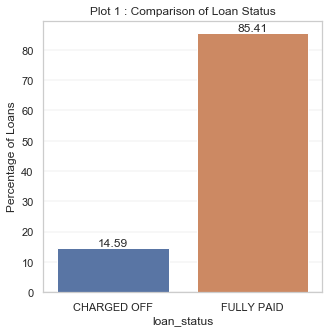

In [41]:
plt.figure(figsize=(5,5))
ax = sns.barplot(data=loan_status_group,x='loan_status',y='Percentage of Loans')
ax.set_title('Plot 1 : Comparison of Loan Status')
create_label(ax,'float')
plt.show()

Observation : It can be seen that 14% of all the issued loans under consideration has been charged-off and resulted in credit-loss for the company. Need to look into the issue.

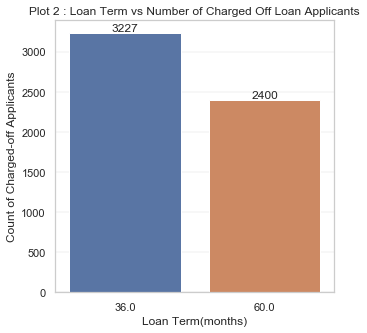

In [42]:
#Analysis of Loan Term versus Count of Charged-Off Loans
plt.figure(figsize=(5,5))
loan_term_charged_off = pd.DataFrame(chargedoff_loan.groupby('term').size()).reset_index().rename(columns={0:'Number of Applicants'})
ax = sns.barplot(data=loan_term_charged_off,x='term',y='Number of Applicants',palette="deep")
ax.set_title('Plot 2 : Loan Term vs Number of Charged Off Loan Applicants')
ax.set_xlabel('Loan Term(months)')
ax.set_ylabel('Count of Charged-off Applicants')
create_label(ax,'integer')
#change_width(ax, .5)
plt.show()

Observation : Number of charged-off loans for 3 years is higher than that of 5 years. 

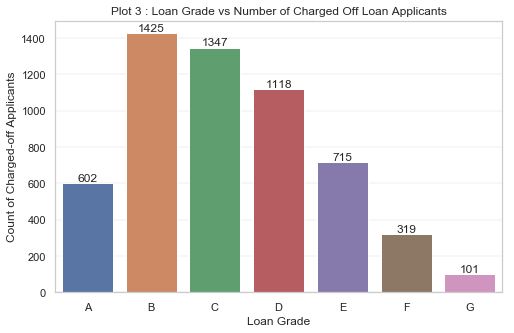

In [43]:
#Analysis of LC assigned grade versus Count of Charged-Off Loans
plt.figure(figsize=(8,5))
loan_grade_charged_off = pd.DataFrame(chargedoff_loan.groupby('grade').size()).reset_index().rename(columns={0:'Number of Applicants'})
ax = sns.barplot(data=loan_grade_charged_off,x='grade',y='Number of Applicants')
ax.set_title('Plot 3 : Loan Grade vs Number of Charged Off Loan Applicants')
ax.set_xlabel('Loan Grade')
ax.set_ylabel('Count of Charged-off Applicants')
create_label(ax,'integer')
plt.show()

Observation : LC Grades B,C and D contribute to the majority number of charged-off loans.

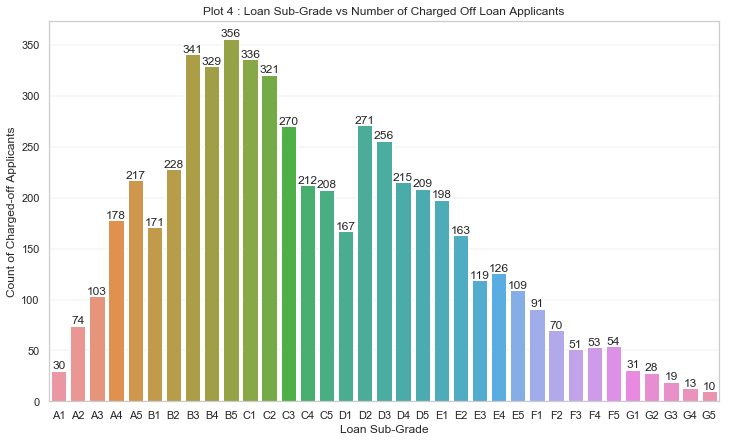

In [44]:
#Analysis of LC assigned sub_grade versus Count of Charged-Off Loans
plt.figure(figsize=(12,7))
loan_sub_grade_charged_off = pd.DataFrame(chargedoff_loan.groupby('sub_grade').size()).reset_index().rename(columns={0:'Number of Applicants'})
ax = sns.barplot(data=loan_sub_grade_charged_off,x='sub_grade',y='Number of Applicants')
ax.set_title('Plot 4 : Loan Sub-Grade vs Number of Charged Off Loan Applicants')
ax.set_xlabel('Loan Sub-Grade')
ax.set_ylabel('Count of Charged-off Applicants')
create_label(ax,'integer')
plt.show()

Observation : The highest number of charged-off loans are in B3~C3 and also D2~D5 sub-grades.

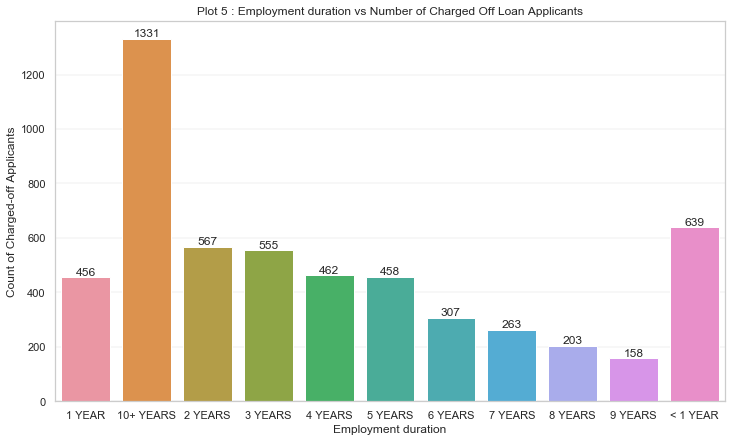

In [45]:
#Analysis of Employment Length versus Count of Charged-Off Loans
plt.figure(figsize=(12,7))
loan_emp_length_charged_off = pd.DataFrame(chargedoff_loan.groupby('emp_length').size()).reset_index().rename(columns={0:'Number of Applicants'})
ax = sns.barplot(data=loan_emp_length_charged_off,x='emp_length',y='Number of Applicants')
ax.set_title('Plot 5 : Employment duration vs Number of Charged Off Loan Applicants')
ax.set_xlabel('Employment duration')
ax.set_ylabel('Count of Charged-off Applicants')
create_label(ax,'integer')
plt.show()

Observation : Charged-off loans has a decreasing trend with respect to employee employment tenure. However charged-off loans for employment duration less than 1 year and beyond 10 years are considerably high.

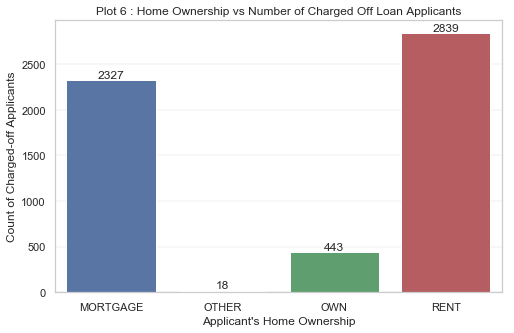

In [46]:
#Analysis of Home Ownership on Count of Charged-off Loans.
plt.figure(figsize=(8,5))
loan_home_charged_off = pd.DataFrame(chargedoff_loan.groupby('home_ownership').size()).reset_index().rename(columns={0:'Number of Applicants'})
ax = sns.barplot(data=loan_home_charged_off,x='home_ownership',y='Number of Applicants')
ax.set_title('Plot 6 : Home Ownership vs Number of Charged Off Loan Applicants')
ax.set_xlabel("Applicant's Home Ownership")
ax.set_ylabel('Count of Charged-off Applicants')
create_label(ax,'integer')
plt.show()

Observation : Applicant's having Rented or Mortgaged accomodation have higher cases of charged-off loans.

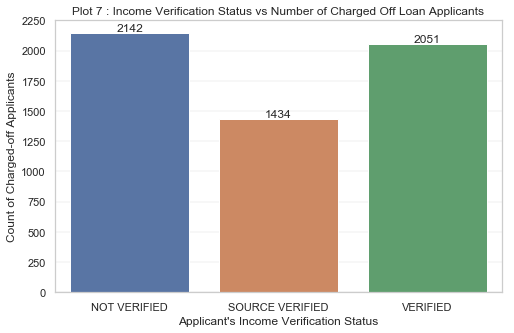

In [47]:
#Analysis of Verification Status vs Count of Charged-Off Loans.
plt.figure(figsize=(8,5))
loan_home_charged_off = pd.DataFrame(chargedoff_loan.groupby('verification_status').size()).reset_index().rename(columns={0:'Number of Applicants'})
ax = sns.barplot(data=loan_home_charged_off,x='verification_status',y='Number of Applicants')
ax.set_title('Plot 7 : Income Verification Status vs Number of Charged Off Loan Applicants')
ax.set_xlabel("Applicant's Income Verification Status")
ax.set_ylabel('Count of Charged-off Applicants')
create_label(ax,'integer')
plt.show()

Observation : Number of charged-off loans for applicants with not verified income is more than that of verifed and source-verified.

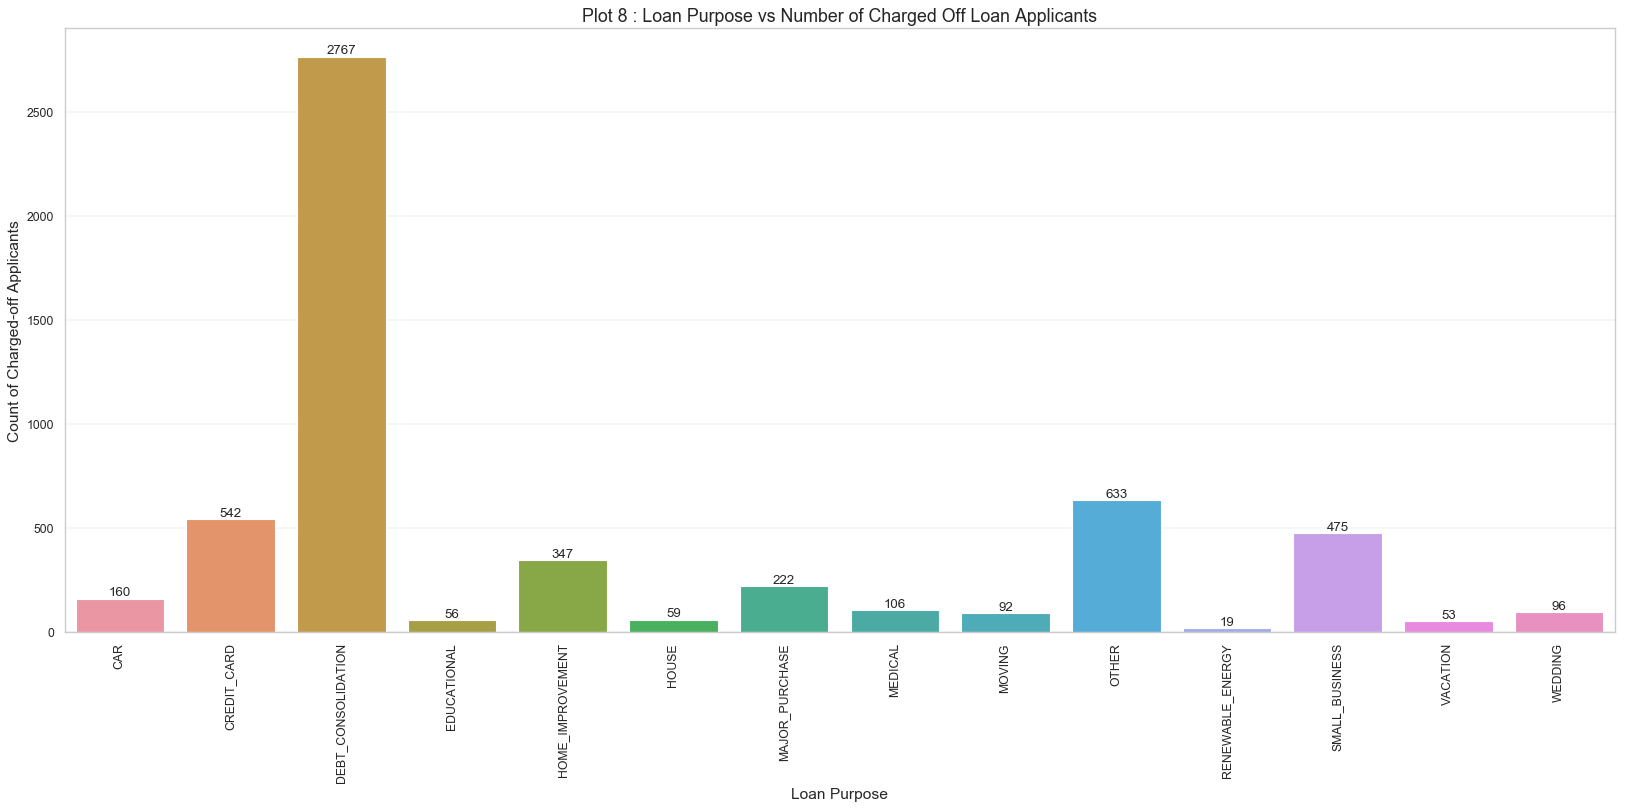

In [48]:
#Analysis of Loan_Purpose Vs. Count of Charged-Off Loans.
plt.figure(figsize=(25,10),dpi=80)
loan_purpose_charged_off = pd.DataFrame(chargedoff_loan.groupby('purpose').size()).reset_index().rename(columns={0:'Number of Applicants'})
ax = sns.barplot(data=loan_purpose_charged_off,x='purpose',y='Number of Applicants')
ax.set_title('Plot 8 : Loan Purpose vs Number of Charged Off Loan Applicants',fontsize=16)
ax.set_xlabel("Loan Purpose",fontsize=14)
ax.set_ylabel('Count of Charged-off Applicants',fontsize=14)
create_label(ax,'integer')
plt.xticks(rotation=90)
plt.show()

Observation : Number of charged-off loans is highest for debt consolidation. Also a high number of applicant's for 'Others' category signifies that the data collection method is not adequate, company needs to incorporate more number of purpose's which applicant can select during loan application.

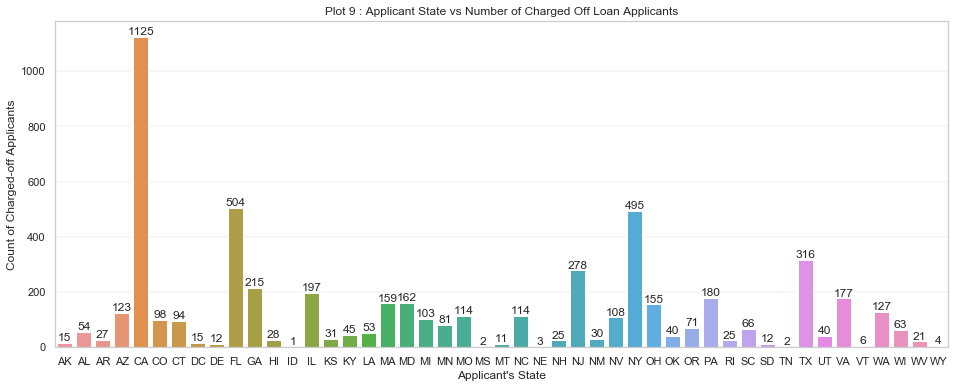

In [49]:
#Analysis of Applicant Residence State Vs Count of Charged-Off Loans
plt.figure(figsize=(16,6))
loan_state_charged_off = pd.DataFrame(chargedoff_loan.groupby('addr_state').size()).reset_index().rename(columns={0:'Number of Applicants'})
ax = sns.barplot(data=loan_state_charged_off,x='addr_state',y='Number of Applicants')
ax.set_title('Plot 9 : Applicant State vs Number of Charged Off Loan Applicants')
ax.set_xlabel("Applicant's State")
ax.set_ylabel('Count of Charged-off Applicants')
create_label(ax,'integer')
plt.show()

Observation : California, Florida, New-York, Texas, New-Jersey are the states having very high number of defaulters.

** Univariate Analysis of Quantitative Variables **

In [50]:
chargedoff_loan.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,pub_rec_bankruptcies
1,1077430,1314167,2500,2500,2500.0,60.0,15.27,59.83,C,C4,RYDER,< 1 YEAR,RENT,30000.0,SOURCE VERIFIED,2011-12-01,CHARGED OFF,CAR,309XX,GA,1.00,0,1999-04-01,5,NaN,3,0,1687,9.4,4,0.0,0.0,1008.71,1008.71,456.46,435.17,0.0,117.08,1.1100,2013-04-01,119.66,2013-09-01,0.0
8,1071795,1306957,5600,5600,5600.0,60.0,21.28,152.39,F,F2,NaN,4 YEARS,OWN,40000.0,SOURCE VERIFIED,2011-12-01,CHARGED OFF,SMALL_BUSINESS,958XX,CA,5.55,0,2004-04-01,2,NaN,11,0,5210,32.6,13,0.0,0.0,646.02,646.02,162.02,294.94,0.0,189.06,2.0900,2012-04-01,152.39,2012-08-01,0.0
9,1071570,1306721,5375,5375,5350.0,60.0,12.69,121.45,B,B5,STARBUCKS,< 1 YEAR,RENT,15000.0,VERIFIED,2011-12-01,CHARGED OFF,OTHER,774XX,TX,18.08,0,2004-09-01,0,NaN,2,0,9279,36.5,3,0.0,0.0,1476.19,1469.34,673.48,533.42,0.0,269.29,2.5200,2012-11-01,121.45,2013-03-01,0.0
12,1064687,1298717,9000,9000,9000.0,36.0,13.49,305.38,C,C1,VA. DEPT OF CONSERVATION/RECREATION,< 1 YEAR,RENT,30000.0,SOURCE VERIFIED,2011-12-01,CHARGED OFF,DEBT_CONSOLIDATION,245XX,VA,10.08,0,2004-04-01,1,NaN,4,0,10452,91.7,9,0.0,0.0,2270.70,2270.70,1256.14,570.26,0.0,444.30,4.1600,2012-07-01,305.38,2012-11-01,0.0
14,1069057,1303503,10000,10000,10000.0,36.0,10.65,325.74,B,B2,SFMTA,3 YEARS,RENT,100000.0,SOURCE VERIFIED,2011-12-01,CHARGED OFF,OTHER,951XX,CA,7.06,0,1991-05-01,2,NaN,14,0,11997,55.5,29,0.0,0.0,7471.99,7471.99,5433.47,1393.42,0.0,645.10,6.3145,2013-10-01,325.74,2014-03-01,0.0


In [51]:
##Loan Amount Analysis
loan_data['loan_amnt'].describe()

count    39713.000000
mean     11220.150832
std       7456.707871
min        500.000000
25%       5500.000000
50%      10000.000000
75%      15000.000000
max      35000.000000
Name: loan_amnt, dtype: float64

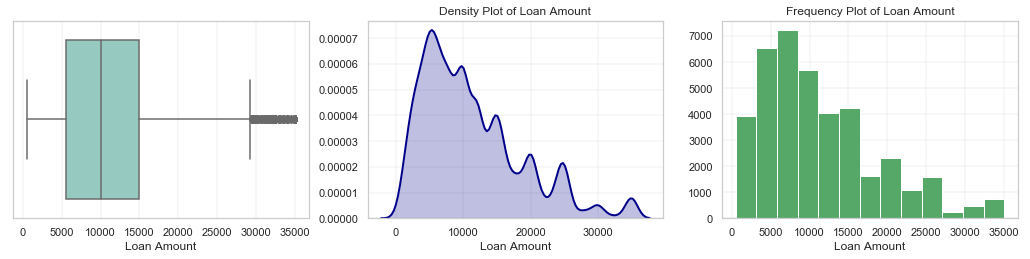

In [52]:
plt.figure(figsize=(18, 8))
plt.subplot(2, 3, 1)
ax = sns.boxplot(x=loan_data['loan_amnt'],palette="Set3")
plt.xlabel('Loan Amount')

plt.subplot(2, 3, 2)
plt.title('Density Plot of Loan Amount')
ay = sns.distplot(loan_data['loan_amnt'], hist=False, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'shade': True,'linewidth': 2},bins=13)
plt.xlabel('Loan Amount')

plt.subplot(2, 3, 3)
plt.hist(loan_data['loan_amnt'],color='g',bins=13)
plt.title('Frequency Plot of Loan Amount')
plt.xlabel('Loan Amount')
plt.show()

From the above box-plot and distribution it is evident that loan amount is approxiamtely a gaussian distribution and has outliers at the far end.

In [53]:
##Interest Rate
loan_data['int_rate'].describe()

count    39713.000000
mean        12.021535
std          3.724833
min          5.420000
25%          9.250000
50%         11.860000
75%         14.590000
max         24.590000
Name: int_rate, dtype: float64

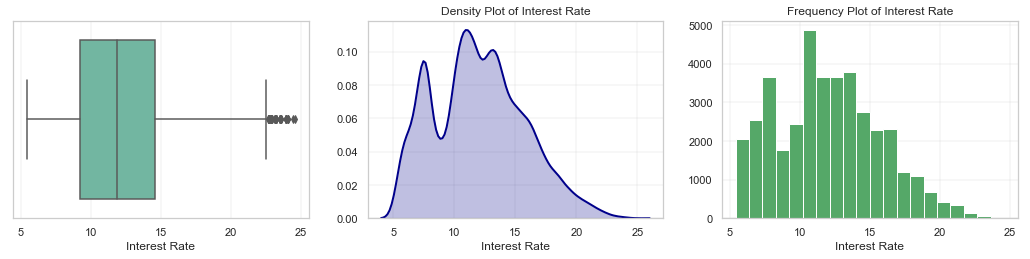

In [54]:
plt.figure(figsize=(18, 8))
plt.subplot(2, 3, 1)
ax = sns.boxplot(x=loan_data['int_rate'],palette="Set2")
plt.xlabel('Interest Rate')


plt.subplot(2, 3, 2)
plt.title('Density Plot of Interest Rate')
ay = sns.distplot(loan_data['int_rate'], hist=False, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'shade': True,'linewidth': 2},bins=20)
plt.xlabel('Interest Rate')


plt.subplot(2, 3, 3)
plt.hist(loan_data['int_rate'],color='g',bins=20)
plt.title('Frequency Plot of Interest Rate')
plt.xlabel('Interest Rate')

plt.show()

From the box-plot and the distribution, we can see that the count of loans with interest rate spikes between 7-8% and again between 11-13%

In [55]:
##Loan_Installment Analysis
loan_data['installment'].describe()

count    39713.000000
mean       324.581285
std        208.876297
min         15.690000
25%        167.040000
50%        280.260000
75%        430.780000
max       1305.190000
Name: installment, dtype: float64

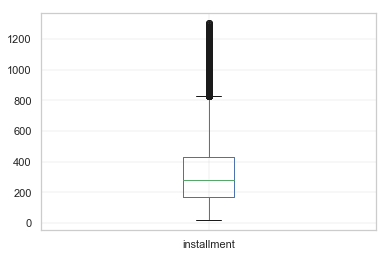

In [56]:
ax = loan_data['installment'].plot(kind='box')
plt.show()

It has a considerable high outliers as evident from the mean and median. Let's remove the outliers outside 5% and 95% quartile and proceed with the analysis.

In [57]:
P = np.percentile(loan_data.installment, [5, 95])
loan_data_installment_filtered = loan_data[(loan_data.installment >= P[0]) & (loan_data.installment <= P[1])]
loan_data_installment_filtered.installment.describe()

count    35741.000000
mean       308.729492
std        161.655532
min         71.250000
25%        176.560000
50%        280.260000
75%        406.620000
max        762.950000
Name: installment, dtype: float64

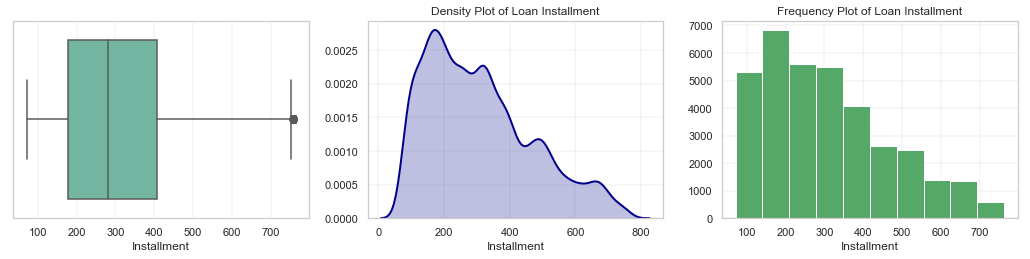

In [58]:
plt.figure(figsize=(18, 8))
plt.subplot(2, 3, 1)
ax = sns.boxplot(x=loan_data_installment_filtered['installment'],palette="Set2")
plt.xlabel('Installment')


plt.subplot(2, 3, 2)
plt.title('Density Plot of Loan Installment')
ay = sns.distplot(loan_data_installment_filtered['installment'], hist=False, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'shade': True,'linewidth': 2})
plt.xlabel('Installment')


plt.subplot(2, 3, 3)
plt.hist(loan_data_installment_filtered['installment'],color='g')
plt.title('Frequency Plot of Loan Installment')
plt.xlabel('Installment')

plt.show()

From the plots it can be observed that the majority of installment amount is less than 400$.

In [59]:
##Annual Income Analysis
loan_data['annual_inc'].describe()

count    3.971300e+04
mean     6.896278e+04
std      6.379270e+04
min      4.000000e+03
25%      4.040000e+04
50%      5.900000e+04
75%      8.229600e+04
max      6.000000e+06
Name: annual_inc, dtype: float64

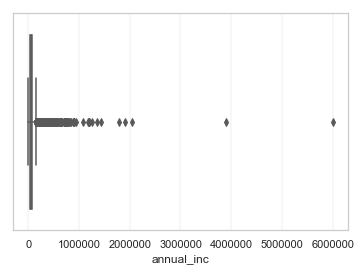

In [60]:
sns.boxplot(x=loan_data['annual_inc'],palette="Set2")

It can be seen from the box-plot that there are significant ouliers on the higher side.Lets restrict the upper bound using 95 percentile.

In [61]:
P = np.percentile(loan_data.annual_inc, [5, 95])
loan_data_income_filtered = loan_data[(loan_data.annual_inc >= P[0]) & (loan_data.annual_inc <= P[1])]
loan_data_income_filtered.annual_inc.describe()

count     35924.000000
mean      63208.691003
std       26683.444772
min       24000.000000
25%       42000.000000
50%       58800.000000
75%       80000.000000
max      141996.000000
Name: annual_inc, dtype: float64

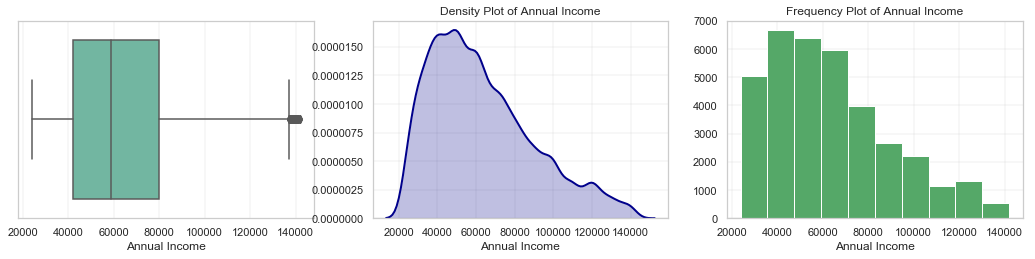

In [62]:
plt.figure(figsize=(18, 8))
plt.subplot(2, 3, 1)
ax = sns.boxplot(x=loan_data_income_filtered['annual_inc'],palette="Set2")
plt.xlabel('Annual Income')


plt.subplot(2, 3, 2)
plt.title('Density Plot of Annual Income')
ay = sns.distplot(loan_data_income_filtered['annual_inc'], hist=False, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'shade': True,'linewidth': 2})
plt.xlabel('Annual Income')


plt.subplot(2, 3, 3)
plt.hist(loan_data_income_filtered['annual_inc'],color='g')
plt.title('Frequency Plot of Annual Income')
plt.xlabel('Annual Income')
#plt.xticks(range(5,26))

plt.show()

In [63]:
#DTI Analysis
loan_data['dti'].describe()

count    39713.000000
mean        13.315564
std          6.678517
min          0.000000
25%          8.180000
50%         13.400000
75%         18.600000
max         29.990000
Name: dti, dtype: float64

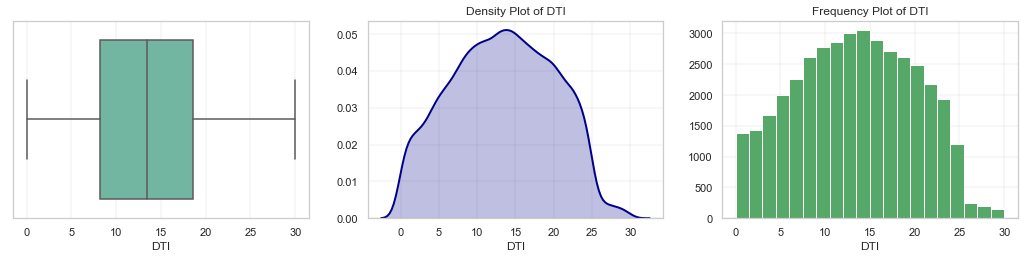

In [64]:
plt.figure(figsize=(18, 8))
plt.subplot(2, 3, 1)
ax = sns.boxplot(x=loan_data['dti'],palette="Set2")
plt.xlabel('DTI')


plt.subplot(2, 3, 2)
plt.title('Density Plot of DTI')
ay = sns.distplot(loan_data['dti'], hist=False, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'shade': True,'linewidth': 2},bins=20)
plt.xlabel('DTI')


plt.subplot(2, 3, 3)
plt.hist(loan_data['dti'],color='g',bins=20)
plt.title('Frequency Plot of DTI')
plt.xlabel('DTI')
#plt.xticks(range(5,26))

plt.show()

From the box-plot and distribution it can be observed that DTI is almost normally distributed with majority between 13-14%.

In [65]:
##Revolving Line Utilization Rate
loan_data['revol_util'].describe()

count    39663.000000
mean        48.835819
std         28.331621
min          0.000000
25%         25.400000
50%         49.300000
75%         72.400000
max         99.900000
Name: revol_util, dtype: float64

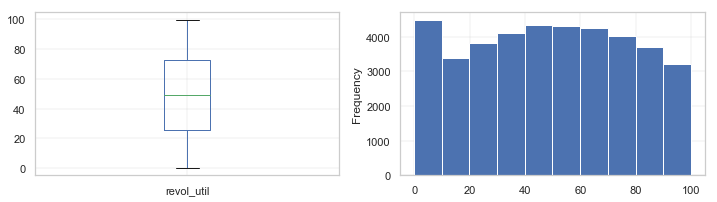

In [66]:
plt.figure(figsize=(12, 3))
plt.subplot(1,2,1)
loan_data['revol_util'].plot(kind='box')

plt.subplot(1,2,2)
loan_data['revol_util'].plot(kind='hist')
plt.show()

Revolving Line Utilization is normally distributed.

### <font color=black> B. Bivariate Analysis</font>

** Bivariate Analysis on categorical variables **

In [67]:
loan_status_df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,pub_rec_bankruptcies
0,1077501,1296599,5000,5000,4975.0,36.0,10.65,162.87,B,B2,NaN,10+ YEARS,RENT,24000.0,VERIFIED,2011-12-01,FULLY PAID,CREDIT_CARD,860XX,AZ,27.65,0,1985-01-01,1,NaN,3,0,13648,83.7,9,5863.155187,5833.84,5000.00,863.16,0.00,0.00,0.00,2015-01-01,171.62,2016-05-01,0.0
1,1077430,1314167,2500,2500,2500.0,60.0,15.27,59.83,C,C4,RYDER,< 1 YEAR,RENT,30000.0,SOURCE VERIFIED,2011-12-01,CHARGED OFF,CAR,309XX,GA,1.00,0,1999-04-01,5,NaN,3,0,1687,9.4,4,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,2013-04-01,119.66,2013-09-01,0.0
2,1077175,1313524,2400,2400,2400.0,36.0,15.96,84.33,C,C5,NaN,10+ YEARS,RENT,12252.0,NOT VERIFIED,2011-12-01,FULLY PAID,SMALL_BUSINESS,606XX,IL,8.72,0,2001-11-01,2,NaN,2,0,2956,98.5,10,3005.666844,3005.67,2400.00,605.67,0.00,0.00,0.00,2014-06-01,649.91,2016-05-01,0.0
3,1076863,1277178,10000,10000,10000.0,36.0,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ YEARS,RENT,49200.0,SOURCE VERIFIED,2011-12-01,FULLY PAID,OTHER,917XX,CA,20.00,0,1996-02-01,1,35.0,10,0,5598,21.0,37,12231.890000,12231.89,10000.00,2214.92,16.97,0.00,0.00,2015-01-01,357.48,2016-04-01,0.0
5,1075269,1311441,5000,5000,5000.0,36.0,7.90,156.46,A,A4,VEOLIA TRANSPORTATON,3 YEARS,RENT,36000.0,SOURCE VERIFIED,2011-12-01,FULLY PAID,WEDDING,852XX,AZ,11.20,0,2004-11-01,3,NaN,9,0,7963,28.3,12,5632.210000,5632.21,5000.00,632.21,0.00,0.00,0.00,2015-01-01,161.03,2016-01-01,0.0


** 1. Anaysis of applicant's loan purpose versus Loan Status **

In [68]:
loan_purpose_df = pd.DataFrame(loan_status_df.groupby(['purpose','loan_status']).size()).reset_index().rename(columns={0:'Number of Applicants'})
loan_purpose_df.head()

,purpose,loan_status,Number of Applicants
0,CAR,CHARGED OFF,160
1,CAR,FULLY PAID,1339
2,CREDIT_CARD,CHARGED OFF,542
3,CREDIT_CARD,FULLY PAID,4485
4,DEBT_CONSOLIDATION,CHARGED OFF,2767


In [69]:
loan_purpose_df_pct = pd.DataFrame(loan_purpose_df.groupby(['purpose','loan_status']).agg({'Number of Applicants':'sum'}))
loan_purpose_df_pct = loan_purpose_df_pct.groupby(level=0).apply(lambda x:round(100 * x / float(x.sum()),2)).reset_index().rename(columns={'Number of Applicants':'Percentage of Applicants'})
loan_purpose_df_pct.head()

,purpose,loan_status,Percentage of Applicants
0,CAR,CHARGED OFF,10.67
1,CAR,FULLY PAID,89.33
2,CREDIT_CARD,CHARGED OFF,10.78
3,CREDIT_CARD,FULLY PAID,89.22
4,DEBT_CONSOLIDATION,CHARGED OFF,15.33


In [70]:
loan_purpose_transpose_df = pd.pivot_table(data=loan_purpose_df,columns='loan_status',values='Number of Applicants',index='purpose').reset_index().rename_axis(None,axis=1)
loan_purpose_transpose_df['TOTAL'] = loan_purpose_transpose_df['CHARGED OFF'] + loan_purpose_transpose_df['FULLY PAID']
loan_purpose_transpose_df['FRAUD PERCENTAGE'] = loan_purpose_transpose_df['CHARGED OFF']/loan_purpose_transpose_df['TOTAL']*100
loan_purpose_transpose_df = loan_purpose_transpose_df.sort_values('FRAUD PERCENTAGE',ascending=False)
loan_purpose_transpose_df

,purpose,CHARGED OFF,FULLY PAID,TOTAL,FRAUD PERCENTAGE
11,SMALL_BUSINESS,475,1279,1754,27.080958
10,RENEWABLE_ENERGY,19,83,102,18.627451
3,EDUCATIONAL,56,269,325,17.230769
9,OTHER,633,3229,3862,16.390471
5,HOUSE,59,308,367,16.076294
8,MOVING,92,484,576,15.972222
7,MEDICAL,106,575,681,15.565345
2,DEBT_CONSOLIDATION,2767,15287,18054,15.326243
12,VACATION,53,322,375,14.133333
4,HOME_IMPROVEMENT,347,2528,2875,12.069565


Although the highest number of loan applications are received for debt consolidation,it is clear that the highest percentage of defaulters state loan purpose as Small Business.
27% of all loans taken for small businesses result in credit loss to the company.

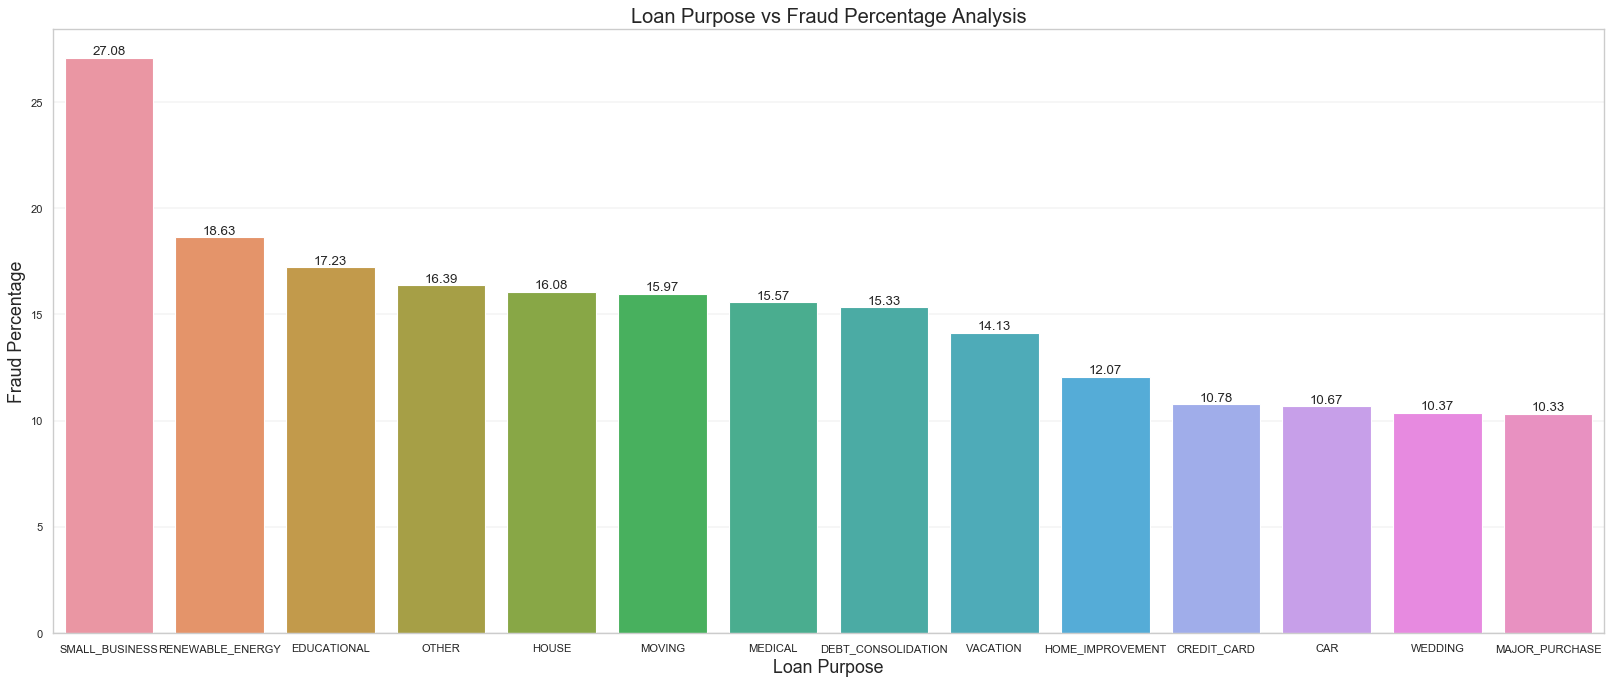

In [71]:
plt.figure(figsize=(25,10),dpi=80)
ax = sns.barplot(data=loan_purpose_transpose_df,x='purpose',y='FRAUD PERCENTAGE')
ax.set_title('Loan Purpose vs Fraud Percentage Analysis',fontsize = 18)
ax.set_xlabel('Loan Purpose',fontsize = 16)
ax.set_ylabel('Fraud Percentage',fontsize = 16)
create_label(ax,'float')
ax.tick_params(labelsize=10)
plt.show()

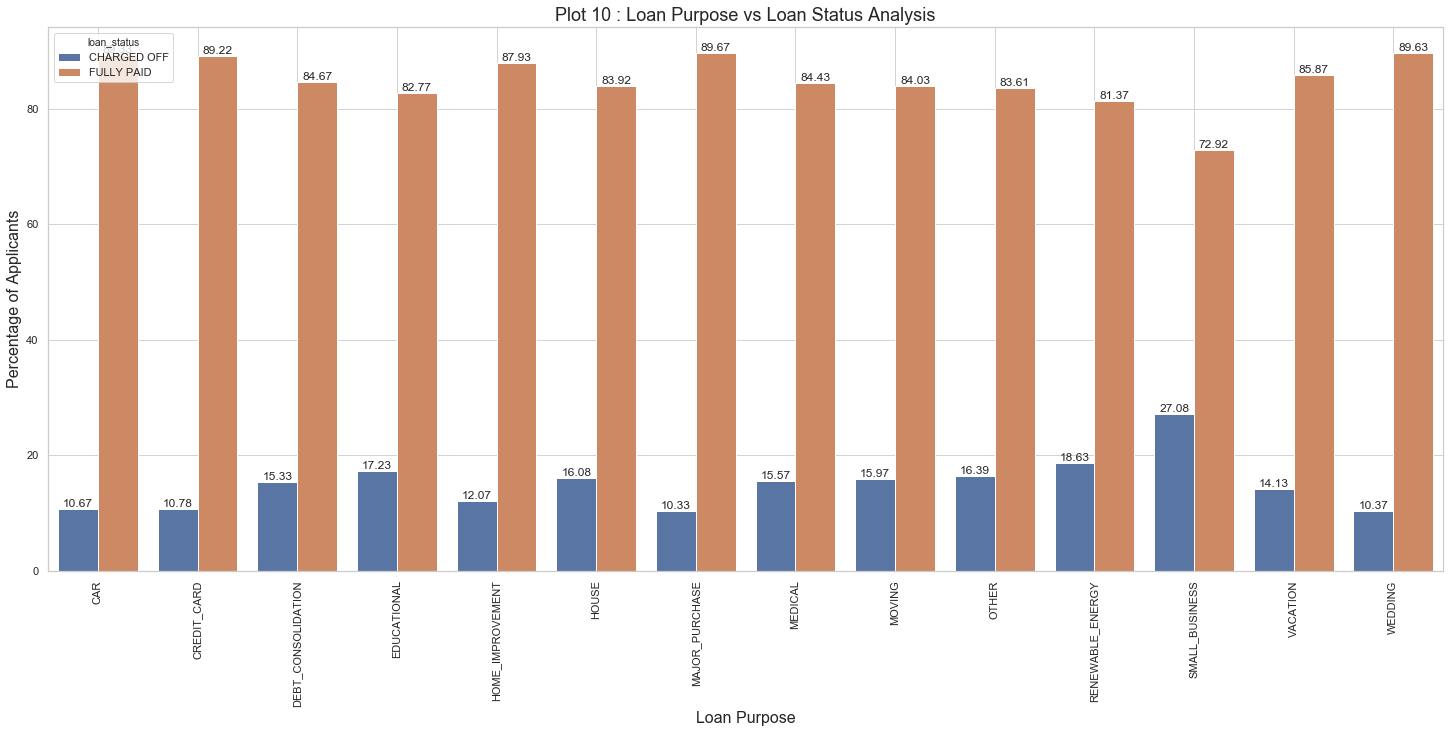

In [72]:
plt.figure(figsize=(25,10))
ax = sns.barplot(data=loan_purpose_df_pct,x='purpose',y='Percentage of Applicants',hue='loan_status')
ax.set_title('Plot 10 : Loan Purpose vs Loan Status Analysis',fontsize = 18)
ax.set_xlabel('Loan Purpose',fontsize = 16)
ax.set_ylabel('Percentage of Applicants',fontsize = 16)
create_label(ax,'float')
plt.xticks(rotation='vertical')
ax.grid(b=True, which='major', color='#d3d3d3', linewidth=1.0)
ax.grid(b=True, which='minor', color='#d3d3d3', linewidth=0.5)
plt.show()

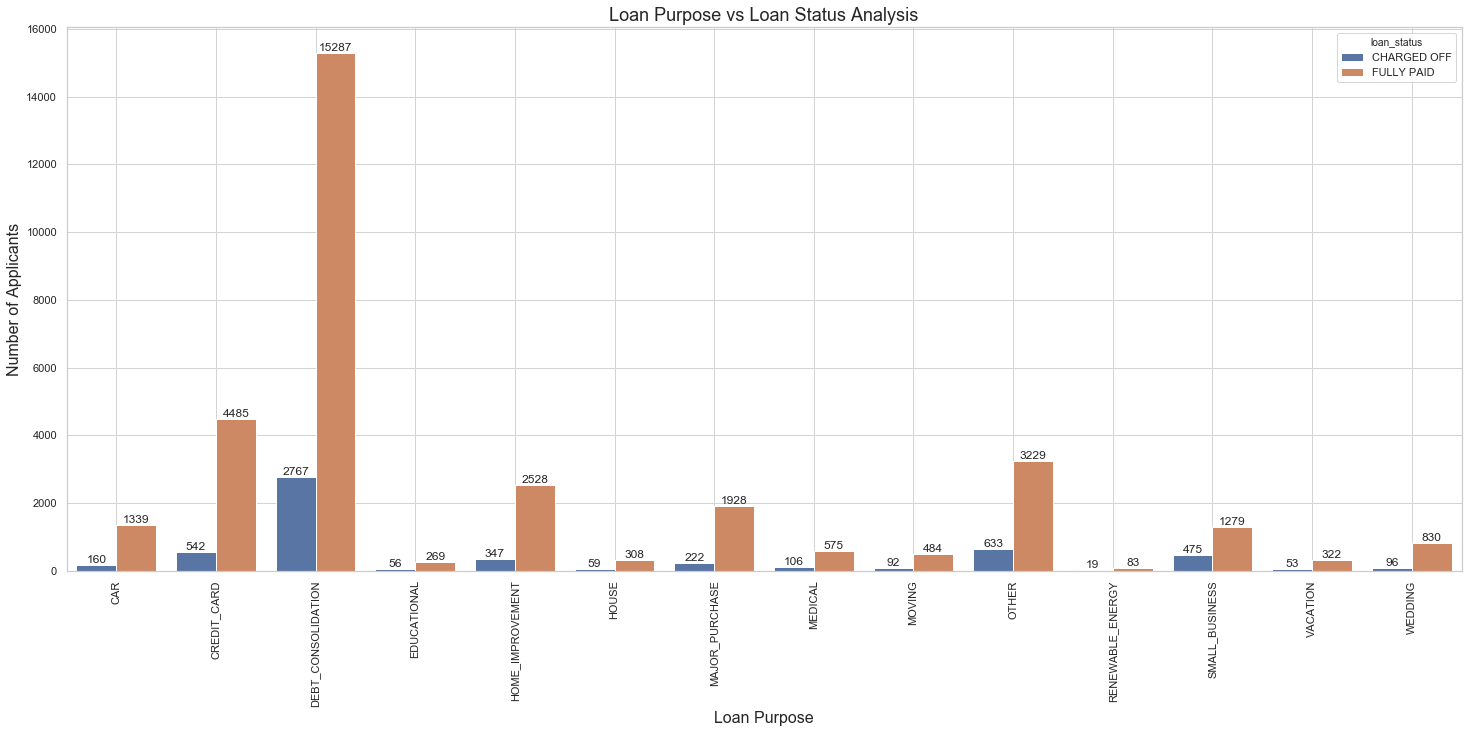

In [73]:
plt.figure(figsize=(25,10))
ax = sns.barplot(data=loan_purpose_df,x='purpose',y='Number of Applicants',hue='loan_status')
ax.set_title('Loan Purpose vs Loan Status Analysis',fontsize = 18)
ax.set_xlabel('Loan Purpose',fontsize = 16)
ax.set_ylabel('Number of Applicants',fontsize = 16)
create_label(ax,'integer')
plt.xticks(rotation='vertical')
ax.grid(b=True, which='major', color='#d3d3d3', linewidth=1.0)
ax.grid(b=True, which='minor', color='#d3d3d3', linewidth=0.5)
plt.show()

** 2. Anaysis of applicant's income verification status versus Loan Status **

In [74]:
loan_verification_df = pd.DataFrame(loan_status_df.groupby(['verification_status','loan_status']).size()).reset_index().rename(columns={0:'Number of Applicants'})
loan_verification_df

,verification_status,loan_status,Number of Applicants
0,NOT VERIFIED,CHARGED OFF,2142
1,NOT VERIFIED,FULLY PAID,14548
2,SOURCE VERIFIED,CHARGED OFF,1434
3,SOURCE VERIFIED,FULLY PAID,8243
4,VERIFIED,CHARGED OFF,2051
5,VERIFIED,FULLY PAID,10155


In [75]:
loan_verification_df_pct = pd.DataFrame(loan_verification_df.groupby(['verification_status','loan_status']).agg({'Number of Applicants':'sum'}))
loan_verification_df_pct = loan_verification_df_pct.groupby(level=0).apply(lambda x:round(100 * x / float(x.sum()),2)).reset_index().rename(columns={'Number of Applicants':'Percentage of Applicants'})
loan_verification_df_pct

,verification_status,loan_status,Percentage of Applicants
0,NOT VERIFIED,CHARGED OFF,12.83
1,NOT VERIFIED,FULLY PAID,87.17
2,SOURCE VERIFIED,CHARGED OFF,14.82
3,SOURCE VERIFIED,FULLY PAID,85.18
4,VERIFIED,CHARGED OFF,16.80
5,VERIFIED,FULLY PAID,83.20


In [76]:
loan_verification_transpose_df = pd.pivot_table(data=loan_verification_df,columns='loan_status',values='Number of Applicants',index='verification_status').reset_index().rename_axis(None,axis=1)
loan_verification_transpose_df['TOTAL'] = loan_verification_transpose_df['CHARGED OFF'] + loan_verification_transpose_df['FULLY PAID']
loan_verification_transpose_df['FRAUD PERCENTAGE'] = loan_verification_transpose_df['CHARGED OFF']/loan_verification_transpose_df['TOTAL']*100
loan_verification_transpose_df = loan_verification_transpose_df.sort_values('FRAUD PERCENTAGE',ascending=False)
loan_verification_transpose_df

,verification_status,CHARGED OFF,FULLY PAID,TOTAL,FRAUD PERCENTAGE
2,VERIFIED,2051,10155,12206,16.803212
1,SOURCE VERIFIED,1434,8243,9677,14.818642
0,NOT VERIFIED,2142,14548,16690,12.834032


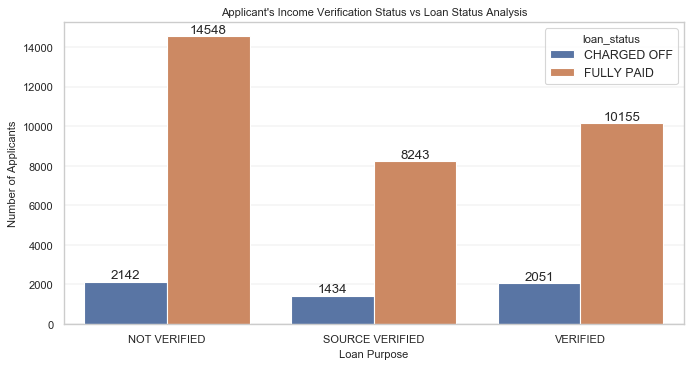

In [77]:
plt.figure(figsize=(10,5),dpi=80)
ax = sns.barplot(data=loan_verification_df,x='verification_status',y='Number of Applicants',hue='loan_status')
ax.set_title("Applicant's Income Verification Status vs Loan Status Analysis",fontsize = 10)
ax.tick_params(labelsize=10)
ax.set_xlabel('Loan Purpose',fontsize = 10)
ax.set_ylabel('Number of Applicants',fontsize = 10)
create_label(ax,'integer')
plt.show()

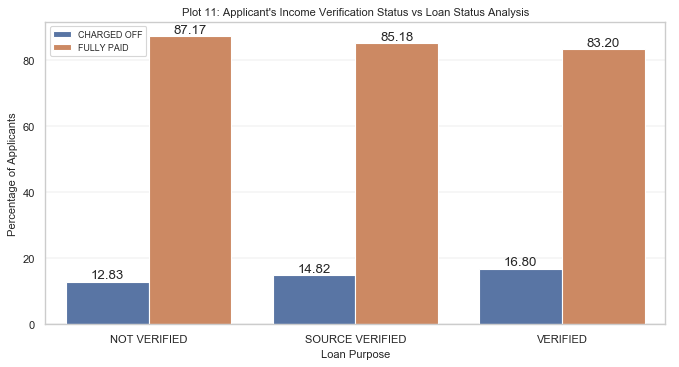

In [78]:
plt.figure(figsize=(10,5),dpi=80)
ax = sns.barplot(data=loan_verification_df_pct,x='verification_status',y='Percentage of Applicants',hue='loan_status')
ax.set_title("Plot 11: Applicant's Income Verification Status vs Loan Status Analysis",fontsize = 10)
ax.tick_params(labelsize=10)
ax.set_xlabel('Loan Purpose',fontsize = 10)
ax.set_ylabel('Percentage of Applicants',fontsize = 10)
ax.legend(loc='upper left', frameon=True,fontsize=8)
create_label(ax,'float')
plt.show()

LC has incorporated a system to review the income source of the loan applicant. 
From the table it is clear that the highest number of applications received not verified. 
However, from the plot 11, it is evident that applications that have the income verified or source verified have a higher chance of leading to credit loss.
LC must appraise and analyze the system implemented for verification.

** 3. Anaysis of applicant's Loan Term status versus Loan Status **

In [79]:
loan_term_df = pd.DataFrame(loan_status_df.groupby(['term','loan_status']).size()).reset_index().rename(columns={0:'Number of Applicants'})
loan_term_df

,term,loan_status,Number of Applicants
0,36.0,CHARGED OFF,3227
1,36.0,FULLY PAID,25865
2,60.0,CHARGED OFF,2400
3,60.0,FULLY PAID,7081


In [80]:
loan_term_df_pct = pd.DataFrame(loan_term_df.groupby(['term','loan_status']).agg({'Number of Applicants':'sum'}))
loan_term_df_pct = loan_term_df_pct.groupby(level=0).apply(lambda x:round(100 * x / float(x.sum()),2)).reset_index().rename(columns={'Number of Applicants':'Percentage of Applicants'})
loan_term_df_pct

,term,loan_status,Percentage of Applicants
0,36.0,CHARGED OFF,11.09
1,36.0,FULLY PAID,88.91
2,60.0,CHARGED OFF,25.31
3,60.0,FULLY PAID,74.69


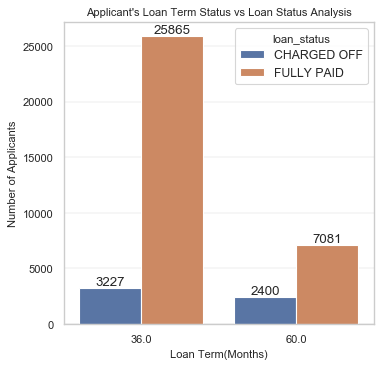

In [81]:
plt.figure(figsize=(5,5),dpi=80)
ax = sns.barplot(data=loan_term_df,x='term',y='Number of Applicants',hue='loan_status')
ax.set_title("Applicant's Loan Term Status vs Loan Status Analysis",fontsize = 10)
ax.tick_params(labelsize=10)
ax.set_xlabel('Loan Term(Months)',fontsize = 10)
ax.set_ylabel('Number of Applicants',fontsize = 10)
create_label(ax,'integer')
plt.show()

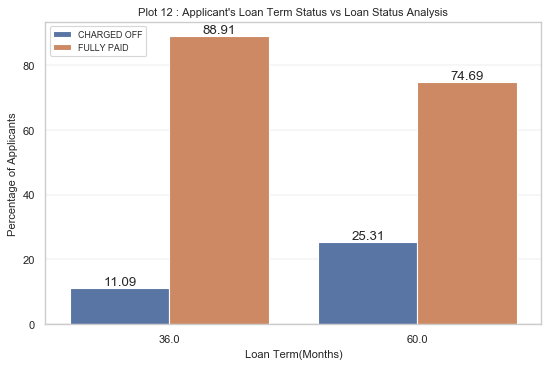

In [82]:
plt.figure(figsize=(8,5),dpi=80)
ax = sns.barplot(data=loan_term_df_pct,x='term',y='Percentage of Applicants',hue='loan_status')
ax.set_title("Plot 12 : Applicant's Loan Term Status vs Loan Status Analysis",fontsize = 10)
ax.tick_params(labelsize=10)
ax.set_xlabel('Loan Term(Months)',fontsize = 10)
ax.set_ylabel('Percentage of Applicants',fontsize = 10)
ax.legend(loc='upper left', frameon=True,fontsize=8)
create_label(ax,'float')
plt.show()

In [83]:
loan_term_transpose_df = pd.pivot_table(data=loan_term_df,columns='loan_status',values='Number of Applicants',index='term').reset_index().rename_axis(None,axis=1)
loan_term_transpose_df['TOTAL'] = loan_term_transpose_df['CHARGED OFF'] + loan_term_transpose_df['FULLY PAID']
loan_term_transpose_df['FRAUD PERCENTAGE'] = loan_term_transpose_df['CHARGED OFF']/loan_term_transpose_df['TOTAL']*100
loan_term_transpose_df = loan_term_transpose_df.sort_values('FRAUD PERCENTAGE',ascending=False)
loan_term_transpose_df

,term,CHARGED OFF,FULLY PAID,TOTAL,FRAUD PERCENTAGE
1,60.0,2400,7081,9481,25.313785
0,36.0,3227,25865,29092,11.092397


Majority of loans are issue for a duration of 36 months. However, from the plot it is clear that a loans issued for a term of 60 months has a significantly higher chance of resulting in credit loss.

** 4. Applicant Residence State vs Loan Status Analysis **

In [84]:
loan_residence_df = pd.DataFrame(loan_status_df.groupby(['addr_state','loan_status']).size()).reset_index().rename(columns={0:'Number of Applicants'})
loan_residence_df.head()

,addr_state,loan_status,Number of Applicants
0,AK,CHARGED OFF,15
1,AK,FULLY PAID,63
2,AL,CHARGED OFF,54
3,AL,FULLY PAID,381
4,AR,CHARGED OFF,27


In [85]:
loan_residence_pvt_df = pd.pivot_table(data=loan_residence_df,columns='loan_status',values='Number of Applicants',index='addr_state').reset_index().rename_axis(None,axis=1)
loan_residence_pvt_df
loan_residence_pvt_df['TOTAL'] = loan_residence_pvt_df['CHARGED OFF'] + loan_residence_pvt_df['FULLY PAID']
loan_residence_pvt_df['FRAUD PERCENTAGE'] = loan_residence_pvt_df['CHARGED OFF']/loan_residence_pvt_df['TOTAL']*100
loan_residence_pvt_df = loan_residence_pvt_df.sort_values('FRAUD PERCENTAGE',ascending=False)
loan_residence_pvt_df.head()

,addr_state,CHARGED OFF,FULLY PAID,TOTAL,FRAUD PERCENTAGE
28,NE,3.0,2.0,5.0,60.000000
32,NV,108.0,371.0,479.0,22.546973
40,SD,12.0,50.0,62.0,19.354839
0,AK,15.0,63.0,78.0,19.230769
9,FL,504.0,2277.0,2781.0,18.122977


It is evident that state with code NE has the highest fraud percentage rate, but the number of applicants is as few as 5. Hence, we drop that row.Also states such as IA,IN and ME has no information so we will drop them too.

In [86]:
loan_residence_pvt_df = loan_residence_pvt_df[~loan_residence_pvt_df['addr_state'].isin(['NE','IA','IN','ME'])]
loan_residence_pvt_df.head()

,addr_state,CHARGED OFF,FULLY PAID,TOTAL,FRAUD PERCENTAGE
32,NV,108.0,371.0,479.0,22.546973
40,SD,12.0,50.0,62.0,19.354839
0,AK,15.0,63.0,78.0,19.230769
9,FL,504.0,2277.0,2781.0,18.122977
24,MO,114.0,556.0,670.0,17.014925


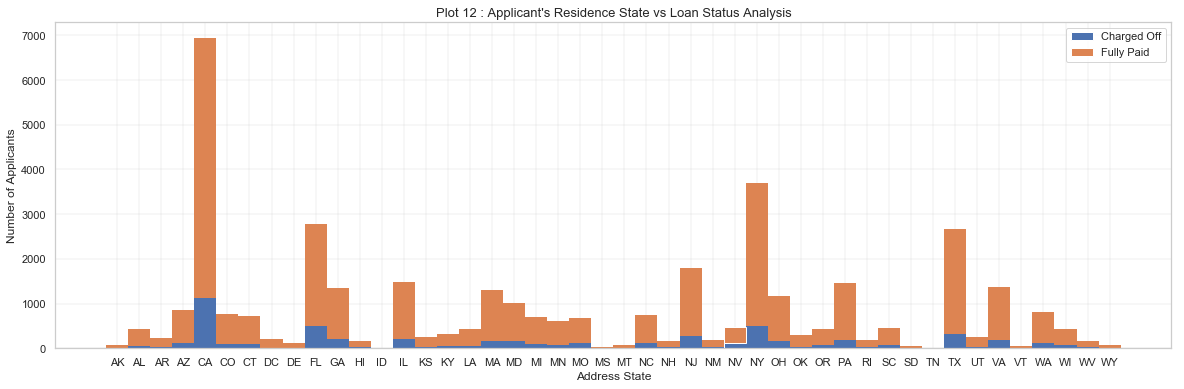

In [87]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,6))

Charged_Off=loan_residence_pvt_df['CHARGED OFF']
Fully_Paid= loan_residence_pvt_df['FULLY PAID']
Status=['Charged Off','Fully Paid']
plt.bar(loan_residence_pvt_df['addr_state'],Charged_Off , edgecolor='white',width=1)
plt.bar(loan_residence_pvt_df['addr_state'],Fully_Paid, bottom=loan_residence_pvt_df['CHARGED OFF'], edgecolor='white', width=1)
# Custom X axis
plt.legend(Status)
plt.title("Plot 12 : Applicant's Residence State vs Loan Status Analysis",fontsize = 13)
plt.xlabel("Address State")
plt.ylabel("Number of Applicants")
plt.show()

In [88]:
loan_residence_pvt_df.sort_values('TOTAL',ascending=False).head()

,addr_state,CHARGED OFF,FULLY PAID,TOTAL,FRAUD PERCENTAGE
4,CA,1125.0,5823.0,6948.0,16.191710
33,NY,495.0,3203.0,3698.0,13.385614
9,FL,504.0,2277.0,2781.0,18.122977
42,TX,316.0,2343.0,2659.0,11.884167
30,NJ,278.0,1512.0,1790.0,15.530726


From the table it is evident that borrowers belonging to Nevraska contribute to the highest default percentage(**22.5%**). The highest number of loan application are recieved from Canada, Florida, New-York and Texas. Their respective default rates are **16.1%,13.4%,18.1% and 11.9%**

** 5. Loan Grade vs Loan Status Analysis **

In [89]:
loan_grade_df = pd.DataFrame(loan_status_df.groupby(['grade','loan_status']).size()).reset_index().rename(columns={0:'Number of Applicants'})
loan_grade_df

,grade,loan_status,Number of Applicants
0,A,CHARGED OFF,602
1,A,FULLY PAID,9441
2,B,CHARGED OFF,1425
3,B,FULLY PAID,10248
4,C,CHARGED OFF,1347
5,C,FULLY PAID,6487
6,D,CHARGED OFF,1118
7,D,FULLY PAID,3967
8,E,CHARGED OFF,715
9,E,FULLY PAID,1948


In [90]:
loan_grade_df_pct = pd.DataFrame(loan_grade_df.groupby(['grade','loan_status']).agg({'Number of Applicants':'sum'}))
loan_grade_df_pct = loan_grade_df_pct.groupby(level=0).apply(lambda x:round(100 * x / float(x.sum()),2)).reset_index().rename(columns={'Number of Applicants':'Percentage of Applicants'})
loan_grade_df_pct

,grade,loan_status,Percentage of Applicants
0,A,CHARGED OFF,5.99
1,A,FULLY PAID,94.01
2,B,CHARGED OFF,12.21
3,B,FULLY PAID,87.79
4,C,CHARGED OFF,17.19
5,C,FULLY PAID,82.81
6,D,CHARGED OFF,21.99
7,D,FULLY PAID,78.01
8,E,CHARGED OFF,26.85
9,E,FULLY PAID,73.15


In [91]:
loan_grade_pvt_df = pd.pivot_table(data=loan_grade_df,columns='loan_status',values='Number of Applicants',index='grade').reset_index().rename_axis(None,axis=1)
loan_grade_pvt_df['TOTAL'] = loan_grade_pvt_df['CHARGED OFF'] + loan_grade_pvt_df['FULLY PAID']
loan_grade_pvt_df['FRAUD PERCENTAGE'] = loan_grade_pvt_df['CHARGED OFF']/loan_grade_pvt_df['TOTAL']*100
loan_grade_pvt_df = loan_grade_pvt_df.sort_values('FRAUD PERCENTAGE',ascending=False)
loan_grade_pvt_df

,grade,CHARGED OFF,FULLY PAID,TOTAL,FRAUD PERCENTAGE
6,G,101,198,299,33.779264
5,F,319,657,976,32.684426
4,E,715,1948,2663,26.849418
3,D,1118,3967,5085,21.986234
2,C,1347,6487,7834,17.194281
1,B,1425,10248,11673,12.207659
0,A,602,9441,10043,5.994225


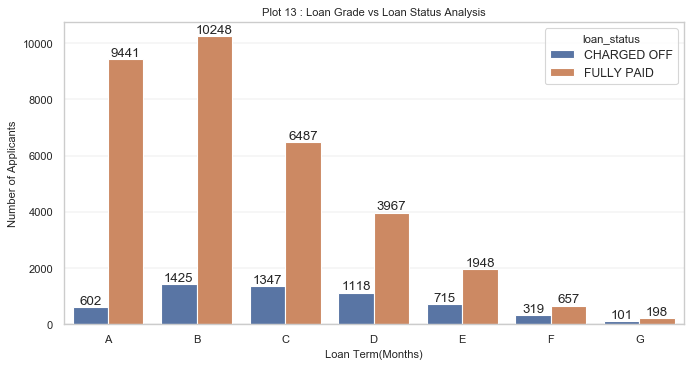

In [92]:
plt.figure(figsize=(10,5),dpi=80)
ax = sns.barplot(data=loan_grade_df,x='grade',y='Number of Applicants',hue='loan_status')
ax.set_title("Plot 13 : Loan Grade vs Loan Status Analysis",fontsize = 10)
ax.tick_params(labelsize=10)
ax.set_xlabel('Loan Term(Months)',fontsize = 10)
ax.set_ylabel('Number of Applicants',fontsize = 10)
create_label(ax,'integer')
plt.show()

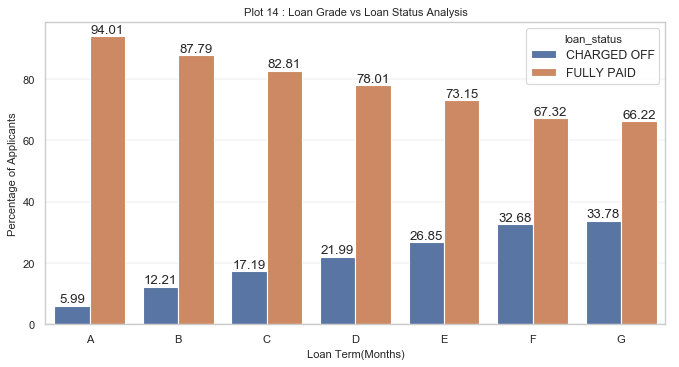

In [93]:
plt.figure(figsize=(10,5),dpi=80)
ax = sns.barplot(data=loan_grade_df_pct,x='grade',y='Percentage of Applicants',hue='loan_status')
ax.set_title("Plot 14 : Loan Grade vs Loan Status Analysis",fontsize = 10)
ax.tick_params(labelsize=10)
ax.set_xlabel('Loan Term(Months)',fontsize = 10)
ax.set_ylabel('Percentage of Applicants',fontsize = 10)
create_label(ax,'float')
plt.show()

From Plot 13, it can be observed that a high frequency of loans belongs to grade A,B,C and D.However when we look at the percentage of default(Plot 14), we could see that there is a clear trend of increase in the percentage of defaulters from grade A to G.(With A having lowest percentage of default and G having highest **33.78%**)

** 5. Loan Sub-Grade vs Loan Status Analysis **

In [94]:
loan_subgrade_df = pd.DataFrame(loan_status_df.groupby(['sub_grade','loan_status']).size()).reset_index().rename(columns={0:'Number of Applicants'})
loan_subgrade_df.head()

,sub_grade,loan_status,Number of Applicants
0,A1,CHARGED OFF,30
1,A1,FULLY PAID,1109
2,A2,CHARGED OFF,74
3,A2,FULLY PAID,1433
4,A3,CHARGED OFF,103


In [95]:
loan_subgrade_pvt_df = pd.pivot_table(data=loan_subgrade_df,columns='loan_status',values='Number of Applicants',index='sub_grade').reset_index().rename_axis(None,axis=1)
loan_subgrade_pvt_df['TOTAL'] = loan_subgrade_pvt_df['CHARGED OFF'] + loan_subgrade_pvt_df['FULLY PAID']
loan_subgrade_pvt_df['FRAUD PERCENTAGE'] = loan_subgrade_pvt_df['CHARGED OFF']/loan_subgrade_pvt_df['TOTAL']*100
loan_subgrade_pvt_df = loan_subgrade_pvt_df.sort_values('FRAUD PERCENTAGE',ascending=False)
loan_subgrade_pvt_df

,sub_grade,CHARGED OFF,FULLY PAID,TOTAL,FRAUD PERCENTAGE
29,F5,54,59,113,47.787611
32,G3,19,26,45,42.222222
31,G2,28,49,77,36.363636
28,F4,53,98,151,35.099338
34,G5,10,19,29,34.482759
30,G1,31,63,94,32.978723
26,F2,70,163,233,30.042918
25,F1,91,214,305,29.836066
23,E4,126,298,424,29.716981
27,F3,51,123,174,29.310345


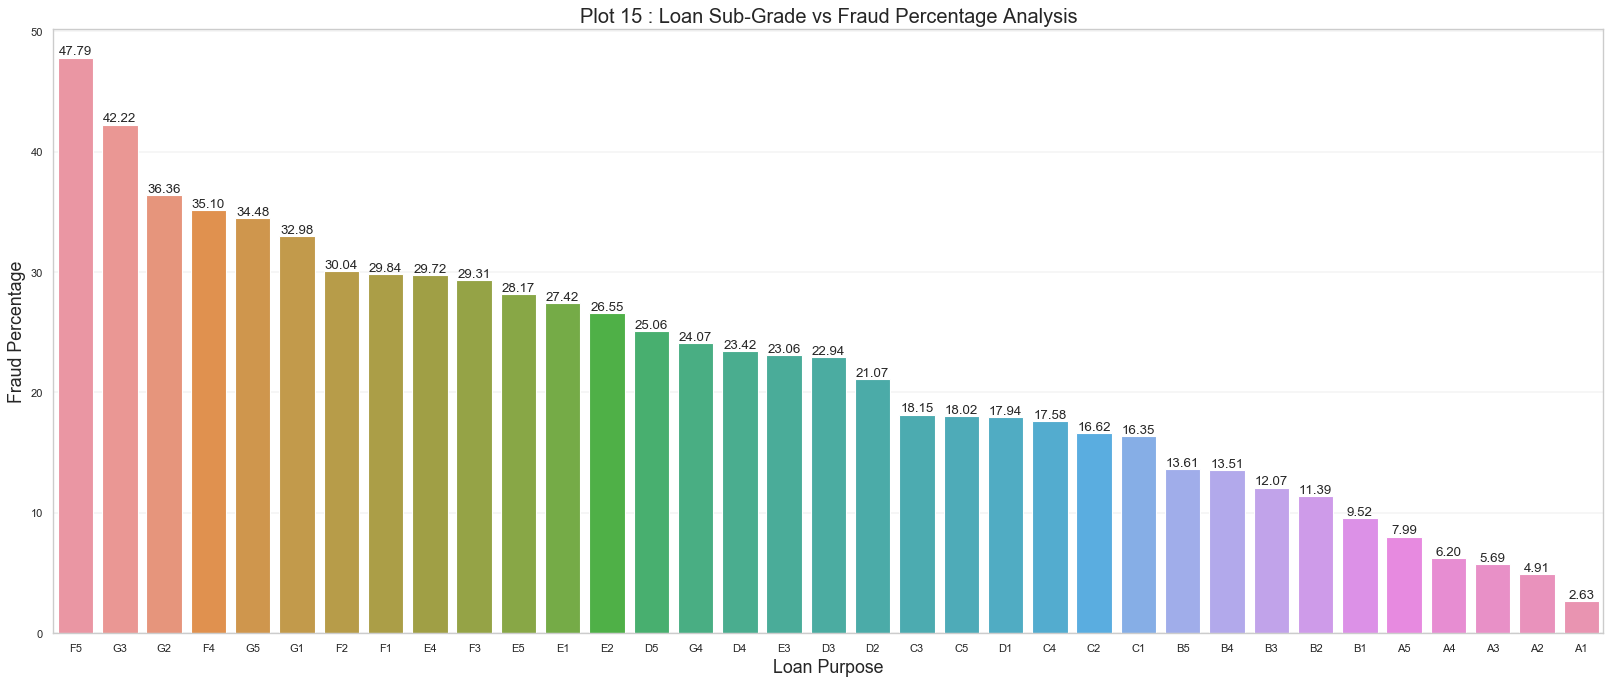

In [96]:
plt.figure(figsize=(25,10),dpi=80)
ax = sns.barplot(data=loan_subgrade_pvt_df,x='sub_grade',y='FRAUD PERCENTAGE')
ax.set_title('Plot 15 : Loan Sub-Grade vs Fraud Percentage Analysis',fontsize = 18)
ax.set_xlabel('Loan Purpose',fontsize = 16)
ax.set_ylabel('Fraud Percentage',fontsize = 16)
create_label(ax,'float')
ax.tick_params(labelsize=10)
plt.show()

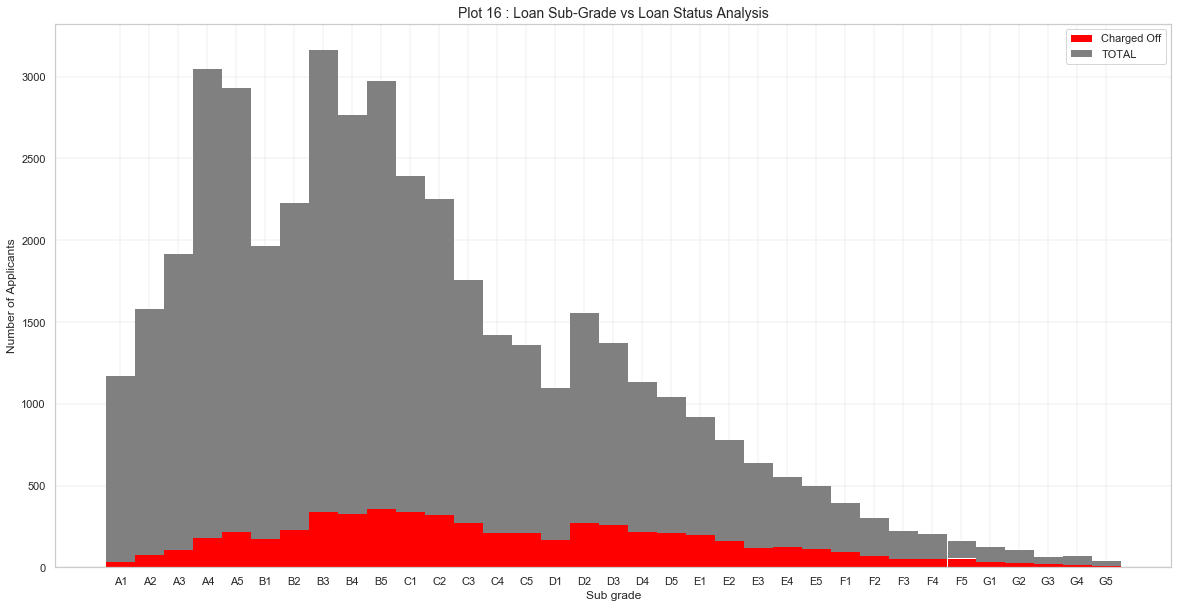

In [97]:
plt.figure(figsize=(20,10))

Charged_Off=loan_subgrade_pvt_df['CHARGED OFF']
TOTAL= loan_subgrade_pvt_df['TOTAL']
Status=['Charged Off','TOTAL']
plt.bar(loan_subgrade_pvt_df['sub_grade'],Charged_Off , color='red', edgecolor='white', width=1)
plt.bar(loan_subgrade_pvt_df['sub_grade'],TOTAL, bottom=loan_subgrade_pvt_df['CHARGED OFF'], color='grey', edgecolor='white', width=1)
plt.legend(Status)
plt.xlabel("Sub grade")
plt.ylabel("Number of Applicants")
plt.title("Plot 16 : Loan Sub-Grade vs Loan Status Analysis",fontsize=14)
plt.show()

On drilling down to the sub-grade level we could observed from Plot.15 that borrowers with sub-grades E1~G5 have the highest chance of resulting in credit loss[** With F5-48% , G3-42%,G2-36% representing the top 3 likely defaulters.**]

** 6. Home Ownership vs Loan Status Analysis **

In [98]:
loan_home_df = pd.DataFrame(loan_status_df.groupby(['home_ownership','loan_status']).size()).reset_index().rename(columns={0:'Number of Applicants'})
loan_home_df

,home_ownership,loan_status,Number of Applicants
0,MORTGAGE,CHARGED OFF,2327
1,MORTGAGE,FULLY PAID,14692
2,NONE,FULLY PAID,1
3,OTHER,CHARGED OFF,18
4,OTHER,FULLY PAID,80
5,OWN,CHARGED OFF,443
6,OWN,FULLY PAID,2532
7,RENT,CHARGED OFF,2839
8,RENT,FULLY PAID,15641


In [99]:
# Remove the row with home_ownership as NONE
loan_home_df = loan_home_df[~(loan_home_df['home_ownership']=='NONE')]
loan_home_df

,home_ownership,loan_status,Number of Applicants
0,MORTGAGE,CHARGED OFF,2327
1,MORTGAGE,FULLY PAID,14692
3,OTHER,CHARGED OFF,18
4,OTHER,FULLY PAID,80
5,OWN,CHARGED OFF,443
6,OWN,FULLY PAID,2532
7,RENT,CHARGED OFF,2839
8,RENT,FULLY PAID,15641


In [100]:
loan_home_df_pct = pd.DataFrame(loan_home_df.groupby(['home_ownership','loan_status']).agg({'Number of Applicants':'sum'}))
loan_home_df_pct = loan_home_df_pct.groupby(level=0).apply(lambda x:round(100 * x / float(x.sum()),2)).reset_index().rename(columns={'Number of Applicants':'Percentage of Applicants'})
loan_home_df_pct

,home_ownership,loan_status,Percentage of Applicants
0,MORTGAGE,CHARGED OFF,13.67
1,MORTGAGE,FULLY PAID,86.33
2,OTHER,CHARGED OFF,18.37
3,OTHER,FULLY PAID,81.63
4,OWN,CHARGED OFF,14.89
5,OWN,FULLY PAID,85.11
6,RENT,CHARGED OFF,15.36
7,RENT,FULLY PAID,84.64


In [101]:
loan_home_pvt_df = pd.pivot_table(data=loan_home_df,columns='loan_status',values='Number of Applicants',index='home_ownership').reset_index().rename_axis(None,axis=1)
loan_home_pvt_df['TOTAL'] = loan_home_pvt_df['CHARGED OFF'] + loan_home_pvt_df['FULLY PAID']
loan_home_pvt_df['FRAUD PERCENTAGE'] = loan_home_pvt_df['CHARGED OFF']/loan_home_pvt_df['TOTAL']*100
loan_home_pvt_df = loan_home_pvt_df.sort_values('FRAUD PERCENTAGE',ascending=False)
loan_home_pvt_df

,home_ownership,CHARGED OFF,FULLY PAID,TOTAL,FRAUD PERCENTAGE
1,OTHER,18,80,98,18.367347
3,RENT,2839,15641,18480,15.362554
2,OWN,443,2532,2975,14.890756
0,MORTGAGE,2327,14692,17019,13.672954


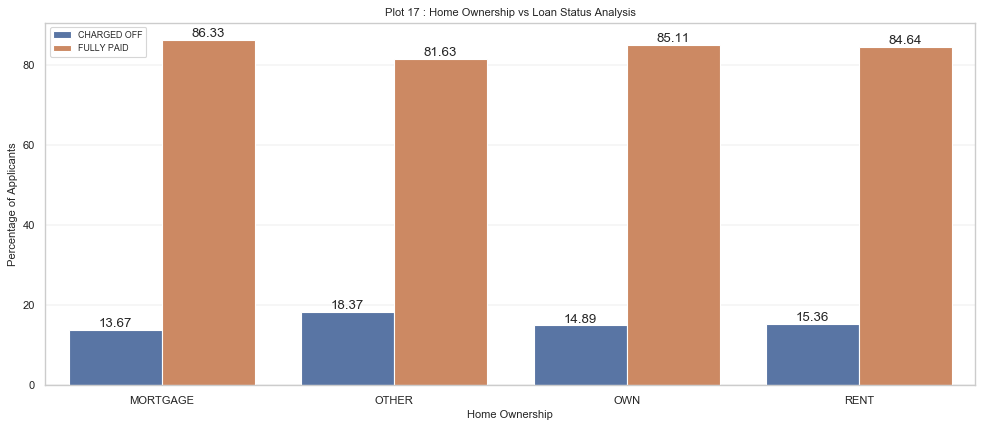

In [102]:
plt.figure(figsize=(15,6),dpi=80)
ax = sns.barplot(data=loan_home_df_pct,x='home_ownership',y='Percentage of Applicants',hue='loan_status')
ax.set_title("Plot 17 : Home Ownership vs Loan Status Analysis",fontsize = 10)
ax.tick_params(labelsize=10)
ax.set_xlabel('Home Ownership',fontsize = 10)
ax.set_ylabel('Percentage of Applicants',fontsize = 10)
ax.legend(loc='upper left', frameon=True,fontsize=8)
create_label(ax,'float')
plt.show()

From the above plot it is clear that applicants who states home ownership as other have higher chances of defaulting the loan payment.From the table it is also clear that majority of the loan applicants state rent or mortgage as home-ownership, from which 15.36% and 13.67% result in credit loss respectively.

** 7. Length of Employment vs Loan Status Analysis **

In [103]:
loan_emplen_df = pd.DataFrame(loan_status_df.groupby(['emp_length','loan_status']).size()).reset_index().rename(columns={0:'Number of Applicants'})
loan_emplen_df

,emp_length,loan_status,Number of Applicants
0,1 YEAR,CHARGED OFF,456
1,1 YEAR,FULLY PAID,2713
2,10+ YEARS,CHARGED OFF,1331
3,10+ YEARS,FULLY PAID,7157
4,2 YEARS,CHARGED OFF,567
5,2 YEARS,FULLY PAID,3724
6,3 YEARS,CHARGED OFF,555
7,3 YEARS,FULLY PAID,3457
8,4 YEARS,CHARGED OFF,462
9,4 YEARS,FULLY PAID,2880


In [104]:
loan_emplen_df_pct = pd.DataFrame(loan_emplen_df.groupby(['emp_length','loan_status']).agg({'Number of Applicants':'sum'}))
loan_emplen_df_pct = loan_emplen_df_pct.groupby(level=0).apply(lambda x:round(100 * x / float(x.sum()),2)).reset_index().rename(columns={'Number of Applicants':'Percentage of Applicants'})
loan_emplen_df_pct

,emp_length,loan_status,Percentage of Applicants
0,1 YEAR,CHARGED OFF,14.39
1,1 YEAR,FULLY PAID,85.61
2,10+ YEARS,CHARGED OFF,15.68
3,10+ YEARS,FULLY PAID,84.32
4,2 YEARS,CHARGED OFF,13.21
5,2 YEARS,FULLY PAID,86.79
6,3 YEARS,CHARGED OFF,13.83
7,3 YEARS,FULLY PAID,86.17
8,4 YEARS,CHARGED OFF,13.82
9,4 YEARS,FULLY PAID,86.18


In [105]:
loan_emplen_pvt_df = pd.pivot_table(data=loan_emplen_df,columns='loan_status',values='Number of Applicants',index='emp_length').reset_index().rename_axis(None,axis=1)
loan_emplen_pvt_df['TOTAL'] = loan_emplen_pvt_df['CHARGED OFF'] + loan_emplen_pvt_df['FULLY PAID']
loan_emplen_pvt_df['FRAUD PERCENTAGE'] = loan_emplen_pvt_df['CHARGED OFF']/loan_emplen_pvt_df['TOTAL']*100
loan_emplen_pvt_df = loan_emplen_pvt_df.sort_values('FRAUD PERCENTAGE',ascending=False)
loan_emplen_pvt_df

,emp_length,CHARGED OFF,FULLY PAID,TOTAL,FRAUD PERCENTAGE
1,10+ YEARS,1331,7157,8488,15.680961
7,7 YEARS,263,1448,1711,15.371128
0,1 YEAR,456,2713,3169,14.389397
5,5 YEARS,458,2736,3194,14.339386
10,< 1 YEAR,639,3865,4504,14.187389
6,6 YEARS,307,1861,2168,14.160517
8,8 YEARS,203,1232,1435,14.146341
3,3 YEARS,555,3457,4012,13.833500
4,4 YEARS,462,2880,3342,13.824057
2,2 YEARS,567,3724,4291,13.213703


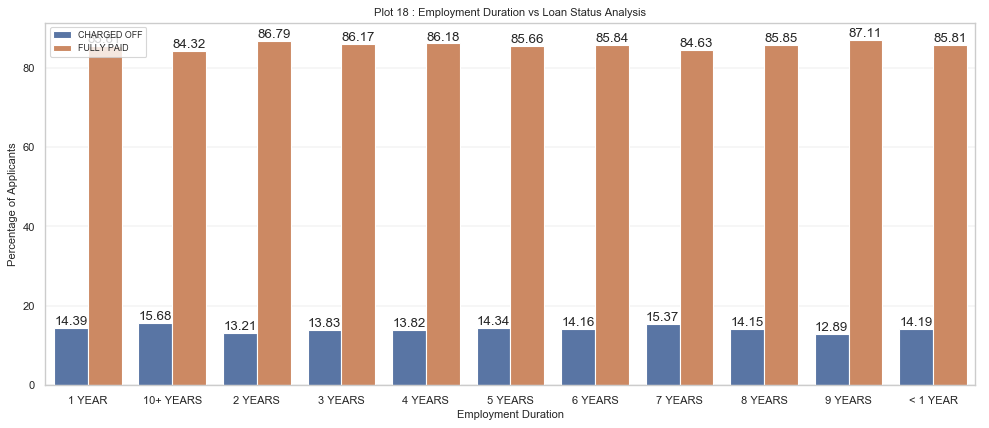

In [106]:
plt.figure(figsize=(15,6),dpi=80)
ax = sns.barplot(data=loan_emplen_df_pct,x='emp_length',y='Percentage of Applicants',hue='loan_status')
ax.set_title("Plot 18 : Employment Duration vs Loan Status Analysis",fontsize = 10)
ax.tick_params(labelsize=10)
ax.set_xlabel('Employment Duration',fontsize = 10)
ax.set_ylabel('Percentage of Applicants',fontsize = 10)
ax.legend(loc='upper left', frameon=True,fontsize=8)
create_label(ax,'float')
plt.show()

From the table it can be observed that the applicants working more than 10 years apply for loan the most number of times and are likely to deafult the most too. The applicants working less than 1 year is likely to default more than the rest.

** 8. Annual Income vs Loan Status Analysis **

We have already seen during univariate analysis that applicant's income has outlier and we need to remove them before proceeding with the analysis.

In [107]:
loan_status_df['annual_inc'].describe()

count    3.857300e+04
mean     6.877162e+04
std      6.421761e+04
min      4.000000e+03
25%      4.000000e+04
50%      5.880000e+04
75%      8.200000e+04
max      6.000000e+06
Name: annual_inc, dtype: float64

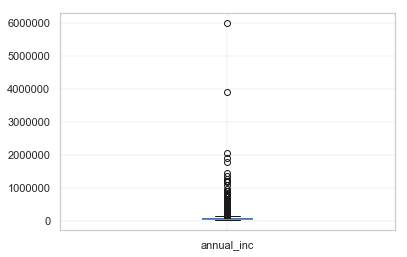

In [108]:
loan_status_df['annual_inc'].plot(kind='box')

In [109]:
# Remove outliers using percentile method
P = np.percentile(loan_status_df.annual_inc, [5, 95])
loan_status_income_filtered = loan_data[(loan_status_df.annual_inc >= P[0]) & (loan_data.annual_inc <= P[1])]
loan_status_income_filtered.annual_inc.describe()

count     34866.000000
mean      63054.784804
std       26624.993810
min       24000.000000
25%       42000.000000
50%       58227.980000
75%       79853.000000
max      140004.000000
Name: annual_inc, dtype: float64

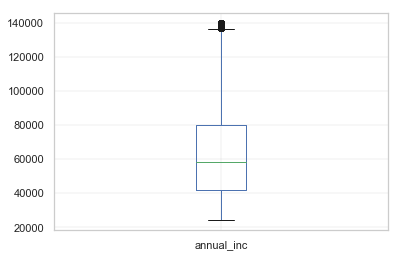

In [110]:
loan_status_income_filtered['annual_inc'].plot(kind='box')

In [111]:
# Create derived metrics for annual income analysis
loan_income_df = pd.DataFrame(loan_status_income_filtered.groupby(['annual_inc','loan_status']).size()).reset_index().rename(columns={0:'Number of Applicants'})
loan_income_df['Income_range']=''
loan_income_df.loc[(loan_income_df['annual_inc']>20000) & (loan_income_df['annual_inc']<=400000),'Income_range']='20,000-40000'
loan_income_df.loc[(loan_income_df['annual_inc']>40000) & (loan_income_df['annual_inc']<=60000),'Income_range']='40,000-60,000'
loan_income_df.loc[(loan_income_df['annual_inc']>60000) & (loan_income_df['annual_inc']<=80000),'Income_range']='60,000-80,000'
loan_income_df.loc[(loan_income_df['annual_inc']>80000),'Income_range']='More than 80,000'

loan_income_df.head()

,annual_inc,loan_status,Number of Applicants,Income_range
0,24000.00,CHARGED OFF,75,"20,000-40000"
1,24000.00,FULLY PAID,326,"20,000-40000"
2,24044.00,FULLY PAID,1,"20,000-40000"
3,24091.68,FULLY PAID,1,"20,000-40000"
4,24100.00,FULLY PAID,1,"20,000-40000"


In [112]:
loan_incomegroup_df = pd.DataFrame(loan_income_df.groupby(['Income_range','loan_status']).size()).reset_index().rename(columns={0:'Number of Applicants'})
loan_incomegroup_df

,Income_range,loan_status,Number of Applicants
0,"20,000-40000",CHARGED OFF,271
1,"20,000-40000",FULLY PAID,795
2,"40,000-60,000",CHARGED OFF,312
3,"40,000-60,000",FULLY PAID,1184
4,"60,000-80,000",CHARGED OFF,197
5,"60,000-80,000",FULLY PAID,902
6,"More than 80,000",CHARGED OFF,247
7,"More than 80,000",FULLY PAID,1030


In [113]:
loan_incomegroup_df_pct = pd.DataFrame(loan_incomegroup_df.groupby(['Income_range','loan_status']).agg({'Number of Applicants':'sum'}))
loan_incomegroup_df_pct = loan_incomegroup_df_pct.groupby(level=0).apply(lambda x:round(100 * x / float(x.sum()),2)).reset_index().rename(columns={'Number of Applicants':'Percentage of Applicants'})
loan_incomegroup_df_pct

,Income_range,loan_status,Percentage of Applicants
0,"20,000-40000",CHARGED OFF,25.42
1,"20,000-40000",FULLY PAID,74.58
2,"40,000-60,000",CHARGED OFF,20.86
3,"40,000-60,000",FULLY PAID,79.14
4,"60,000-80,000",CHARGED OFF,17.93
5,"60,000-80,000",FULLY PAID,82.07
6,"More than 80,000",CHARGED OFF,19.34
7,"More than 80,000",FULLY PAID,80.66


In [114]:
loan_inc_pvt_df = pd.pivot_table(data=loan_incomegroup_df,columns='loan_status',values='Number of Applicants',index='Income_range').reset_index().rename_axis(None,axis=1)
loan_inc_pvt_df['TOTAL'] = loan_inc_pvt_df['CHARGED OFF'] + loan_inc_pvt_df['FULLY PAID']
loan_inc_pvt_df['FRAUD PERCENTAGE'] = loan_inc_pvt_df['CHARGED OFF']/loan_inc_pvt_df['TOTAL']*100
loan_inc_pvt_df = loan_inc_pvt_df.sort_values('FRAUD PERCENTAGE',ascending=False)
loan_inc_pvt_df

,Income_range,CHARGED OFF,FULLY PAID,TOTAL,FRAUD PERCENTAGE
0,"20,000-40000",271,795,1066,25.422139
1,"40,000-60,000",312,1184,1496,20.855615
3,"More than 80,000",247,1030,1277,19.342208
2,"60,000-80,000",197,902,1099,17.925387


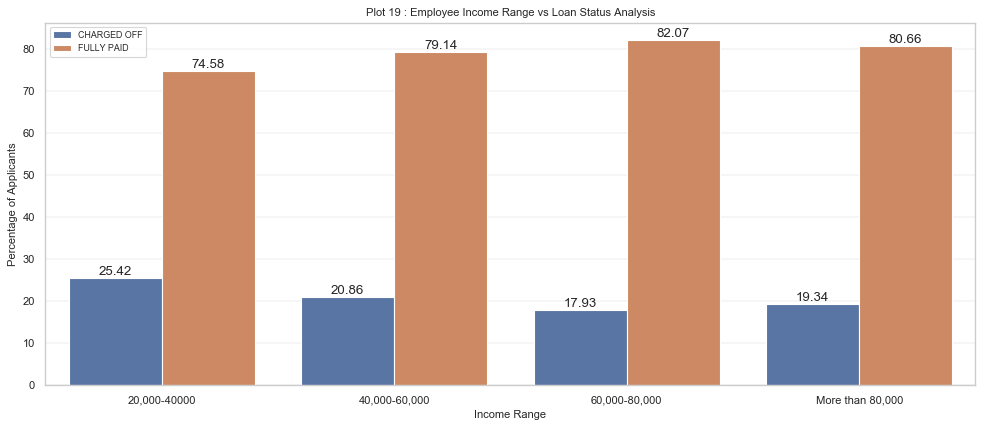

In [115]:
plt.figure(figsize=(15,6),dpi=80)
ax = sns.barplot(data=loan_incomegroup_df_pct,x='Income_range',y='Percentage of Applicants',hue='loan_status')
ax.set_title("Plot 19 : Employee Income Range vs Loan Status Analysis",fontsize = 10)
ax.tick_params(labelsize=10)
ax.set_xlabel('Income Range',fontsize = 10)
ax.set_ylabel('Percentage of Applicants',fontsize = 10)
ax.legend(loc='upper left', frameon=True,fontsize=8)
create_label(ax,'float')
plt.show()

It is observed that as the annual income range increases the percentage of charged-off loans is also decreasing. Highest percentage of charged-off loans lies for income range 20000-40000$.There are some exceptions in the range of more than 80000 since we could see that the fraud percentage is slightly more than the range of 60000-80000.

** 8. Interest Rate vs Loan Status Analysis **

In [116]:
loan_int_df = pd.DataFrame(loan_status_df.groupby(['int_rate','loan_status']).size()).reset_index().rename(columns={0:'Number of Applicants'})
loan_int_df.head()

,int_rate,loan_status,Number of Applicants
0,5.42,CHARGED OFF,20
1,5.42,FULLY PAID,553
2,5.79,CHARGED OFF,16
3,5.79,FULLY PAID,394
4,5.99,CHARGED OFF,19


In [117]:
loan_int_pvt_df = pd.pivot_table(data=loan_int_df,columns='loan_status',values='Number of Applicants',index='int_rate').reset_index().rename_axis(None,axis=1)
loan_int_pvt_df['TOTAL'] = loan_int_pvt_df['CHARGED OFF'] + loan_int_pvt_df['FULLY PAID']
loan_int_pvt_df['FRAUD PERCENTAGE'] = loan_int_pvt_df['CHARGED OFF']/loan_int_pvt_df['TOTAL']*100
loan_int_pvt_df = loan_int_pvt_df.sort_values('FRAUD PERCENTAGE',ascending=False)
loan_int_pvt_df=loan_int_pvt_df[~loan_int_pvt_df['FRAUD PERCENTAGE'].isna()]
loan_int_pvt_df.head()

,int_rate,CHARGED OFF,FULLY PAID,TOTAL,FRAUD PERCENTAGE
351,21.64,2.0,1.0,3.0,66.666667
365,23.52,4.0,2.0,6.0,66.666667
174,13.93,2.0,1.0,3.0,66.666667
363,23.13,5.0,3.0,8.0,62.500000
353,21.74,18.0,11.0,29.0,62.068966


In [118]:
loan_int_pvt_df.loc[loan_int_pvt_df['FRAUD PERCENTAGE']>=51,'Status']='Very High'
loan_int_pvt_df.loc[(loan_int_pvt_df['FRAUD PERCENTAGE']>=35)&(loan_int_pvt_df['FRAUD PERCENTAGE']<51),'Status']='High'
loan_int_pvt_df.loc[(loan_int_pvt_df['FRAUD PERCENTAGE']>=20)&(loan_int_pvt_df['FRAUD PERCENTAGE']<35),'Status']='Mid'
loan_int_pvt_df.loc[(loan_int_pvt_df['FRAUD PERCENTAGE']>=8)&(loan_int_pvt_df['FRAUD PERCENTAGE']<20),'Status']='Low'
loan_int_pvt_df.loc[loan_int_pvt_df['FRAUD PERCENTAGE']<8,'Status']='Very Low'
loan_int_pvt_df.head()

,int_rate,CHARGED OFF,FULLY PAID,TOTAL,FRAUD PERCENTAGE,Status
351,21.64,2.0,1.0,3.0,66.666667,Very High
365,23.52,4.0,2.0,6.0,66.666667,Very High
174,13.93,2.0,1.0,3.0,66.666667,Very High
363,23.13,5.0,3.0,8.0,62.500000,Very High
353,21.74,18.0,11.0,29.0,62.068966,Very High


In [119]:
loan_int_status=pd.DataFrame(loan_int_pvt_df.groupby('Status')['int_rate'].mean().reset_index())
loan_int_status=loan_int_status.sort_values('int_rate',ascending=False)
loan_int_status.rename(columns={'int_rate':'Mean of int_rate','Status':'Fraud Percentage Status'},inplace=True)
loan_int_status

,Fraud Percentage Status,Mean of int_rate
3,Very High,20.296000
0,High,17.432571
2,Mid,16.703761
1,Low,12.626364
4,Very Low,8.356389


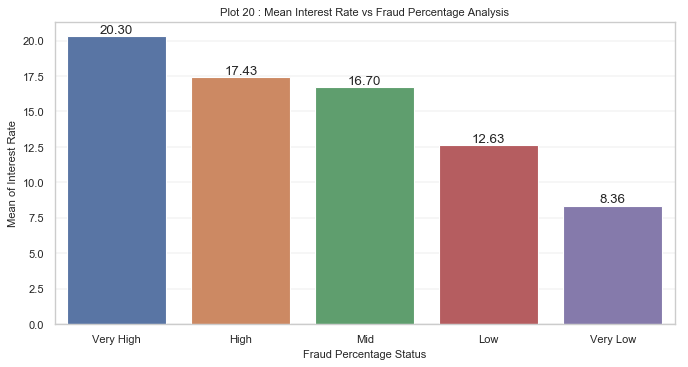

In [120]:
plt.figure(figsize=(10,5),dpi=80)
ax = sns.barplot(data=loan_int_status,x='Fraud Percentage Status',y='Mean of int_rate')
ax.set_title("Plot 20 : Mean Interest Rate vs Fraud Percentage Analysis",fontsize = 10)
ax.tick_params(labelsize=10)
ax.set_xlabel('Fraud Percentage Status',fontsize = 10)
ax.set_ylabel('Mean of Interest Rate',fontsize = 10)
create_label(ax,'float')
plt.show()

It can be inferred from the above plot that with increase in interest rate the percentage of fraud also increases.More likely there will be chances of charged-off loans when interest rate is high.

** 9. Revolving Balance vs Loan Status Analysis **

In credit card terms, a revolving balance is the portion of credit card spending that goes unpaid at the end of a billing cycle. The amount can vary, going up or down depending on the amount borrowed and the amount repaid.<br>
Source: https://www.creditcards.com/

In [121]:
loan_status_df['revol_bal'].describe()

count     38573.000000
mean      13287.974334
std       15862.988147
min           0.000000
25%        3650.000000
50%        8762.000000
75%       16912.000000
max      149588.000000
Name: revol_bal, dtype: float64

In [122]:
# Create derived metric for analysis of revolving balance
loan_status_df.loc[loan_status_df['revol_bal']>=20000,'Revolving Balance Status']='Very High'
loan_status_df.loc[(loan_status_df['revol_bal']>=15000)&(loan_status_df['revol_bal']<20000),'Revolving Balance Status']='High'
loan_status_df.loc[(loan_status_df['revol_bal']>=10000)&(loan_status_df['revol_bal']<15000),'Revolving Balance Status']='Mid'
loan_status_df.loc[(loan_status_df['revol_bal']>=5000)&(loan_status_df['revol_bal']<10000),'Revolving Balance Status']='Low'
loan_status_df.loc[loan_status_df['revol_bal']<5000,'Revolving Balance Status']='Very Low'
loan_status_df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,pub_rec_bankruptcies,Revolving Balance Status
0,1077501,1296599,5000,5000,4975.0,36.0,10.65,162.87,B,B2,NaN,10+ YEARS,RENT,24000.0,VERIFIED,2011-12-01,FULLY PAID,CREDIT_CARD,860XX,AZ,27.65,0,1985-01-01,1,NaN,3,0,13648,83.7,9,5863.155187,5833.84,5000.00,863.16,0.00,0.00,0.00,2015-01-01,171.62,2016-05-01,0.0,Mid
1,1077430,1314167,2500,2500,2500.0,60.0,15.27,59.83,C,C4,RYDER,< 1 YEAR,RENT,30000.0,SOURCE VERIFIED,2011-12-01,CHARGED OFF,CAR,309XX,GA,1.00,0,1999-04-01,5,NaN,3,0,1687,9.4,4,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,2013-04-01,119.66,2013-09-01,0.0,Very Low
2,1077175,1313524,2400,2400,2400.0,36.0,15.96,84.33,C,C5,NaN,10+ YEARS,RENT,12252.0,NOT VERIFIED,2011-12-01,FULLY PAID,SMALL_BUSINESS,606XX,IL,8.72,0,2001-11-01,2,NaN,2,0,2956,98.5,10,3005.666844,3005.67,2400.00,605.67,0.00,0.00,0.00,2014-06-01,649.91,2016-05-01,0.0,Very Low
3,1076863,1277178,10000,10000,10000.0,36.0,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ YEARS,RENT,49200.0,SOURCE VERIFIED,2011-12-01,FULLY PAID,OTHER,917XX,CA,20.00,0,1996-02-01,1,35.0,10,0,5598,21.0,37,12231.890000,12231.89,10000.00,2214.92,16.97,0.00,0.00,2015-01-01,357.48,2016-04-01,0.0,Low
5,1075269,1311441,5000,5000,5000.0,36.0,7.90,156.46,A,A4,VEOLIA TRANSPORTATON,3 YEARS,RENT,36000.0,SOURCE VERIFIED,2011-12-01,FULLY PAID,WEDDING,852XX,AZ,11.20,0,2004-11-01,3,NaN,9,0,7963,28.3,12,5632.210000,5632.21,5000.00,632.21,0.00,0.00,0.00,2015-01-01,161.03,2016-01-01,0.0,Low


In [123]:
loan_revol_df = pd.DataFrame(loan_status_df.groupby(['Revolving Balance Status','loan_status']).size()).reset_index().rename(columns={0:'Number of Applicants'})
loan_revol_df

,Revolving Balance Status,loan_status,Number of Applicants
0,High,CHARGED OFF,577
1,High,FULLY PAID,3243
2,Low,CHARGED OFF,1295
3,Low,FULLY PAID,7474
4,Mid,CHARGED OFF,903
5,Mid,FULLY PAID,5166
6,Very High,CHARGED OFF,1158
7,Very High,FULLY PAID,6320
8,Very Low,CHARGED OFF,1694
9,Very Low,FULLY PAID,10743


In [124]:
loan_revol_pvt_df = pd.pivot_table(data=loan_revol_df,columns='loan_status',values='Number of Applicants',index='Revolving Balance Status').reset_index().rename_axis(None,axis=1)
loan_revol_pvt_df['TOTAL'] = loan_revol_pvt_df['CHARGED OFF'] + loan_revol_pvt_df['FULLY PAID']
loan_revol_pvt_df['FRAUD PERCENTAGE'] = loan_revol_pvt_df['CHARGED OFF']/loan_revol_pvt_df['TOTAL']*100
loan_revol_pvt_df = loan_revol_pvt_df.sort_values('FRAUD PERCENTAGE',ascending=False)
loan_revol_pvt_df=loan_revol_pvt_df[~loan_revol_pvt_df['FRAUD PERCENTAGE'].isna()]
loan_revol_pvt_df

,Revolving Balance Status,CHARGED OFF,FULLY PAID,TOTAL,FRAUD PERCENTAGE
3,Very High,1158,6320,7478,15.485424
0,High,577,3243,3820,15.104712
2,Mid,903,5166,6069,14.878893
1,Low,1295,7474,8769,14.767932
4,Very Low,1694,10743,12437,13.620648


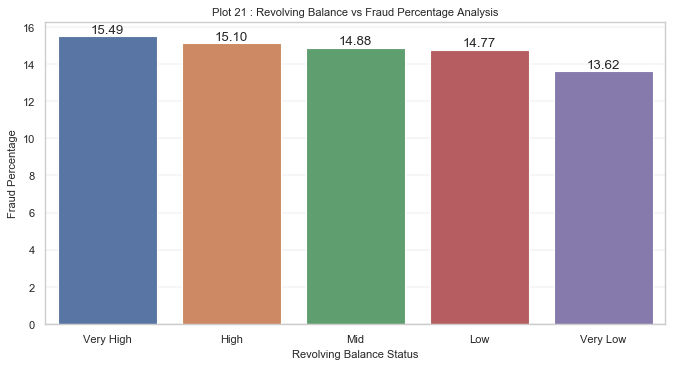

In [125]:
plt.figure(figsize=(10,5),dpi=80)
ax = sns.barplot(data=loan_revol_pvt_df,x='Revolving Balance Status',y='FRAUD PERCENTAGE')
ax.set_title("Plot 21 : Revolving Balance vs Fraud Percentage Analysis",fontsize = 10)
ax.tick_params(labelsize=10)
ax.set_xlabel('Revolving Balance Status',fontsize = 10)
ax.set_ylabel('Fraud Percentage',fontsize = 10)
create_label(ax,'float')
plt.show()

It can be observed from the above plott that with increasing revolving balance the likelihood of being a defaulter also increases.

** 10. Loan Grade vs Interest Rate Analysis **

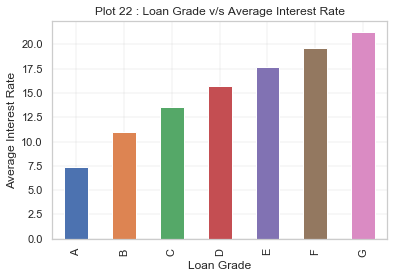

In [126]:
loan_status_df.groupby('grade')['int_rate'].mean().plot(kind='bar')
plt.title('Plot 22 : Loan Grade v/s Average Interest Rate')
plt.ylabel('Average Interest Rate')
plt.xlabel('Loan Grade')
plt.show()

From the above plot it is evident that the interest rate decided by Lending Club depends upon the internal loan grades they have created and also higher the loan grade[A-G], higher is the interest rate.

** 11. Public Record Bankruptcies vs Loan Status Analysis **

In [127]:
loan_status_df['pub_rec_bankruptcies'].describe()

count    37880.000000
mean         0.043479
std          0.204583
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: pub_rec_bankruptcies, dtype: float64

In [128]:
loan_prbc_df = pd.DataFrame(loan_status_df.groupby(['pub_rec_bankruptcies','loan_status']).size()).reset_index().rename(columns={0:'Number of Applicants'})
loan_prbc_df

,pub_rec_bankruptcies,loan_status,Number of Applicants
0,0.0,CHARGED OFF,5141
1,0.0,FULLY PAID,31097
2,1.0,CHARGED OFF,366
3,1.0,FULLY PAID,1271
4,2.0,CHARGED OFF,2
5,2.0,FULLY PAID,3


In [129]:
loan_prbc_df_pct = pd.DataFrame(loan_prbc_df.groupby(['pub_rec_bankruptcies','loan_status']).agg({'Number of Applicants':'sum'}))
loan_prbc_df_pct = loan_prbc_df_pct.groupby(level=0).apply(lambda x:round(100 * x / float(x.sum()),2)).reset_index().rename(columns={'Number of Applicants':'Percentage of Applicants'})
loan_prbc_df_pct

,pub_rec_bankruptcies,loan_status,Percentage of Applicants
0,0.0,CHARGED OFF,14.19
1,0.0,FULLY PAID,85.81
2,1.0,CHARGED OFF,22.36
3,1.0,FULLY PAID,77.64
4,2.0,CHARGED OFF,40.00
5,2.0,FULLY PAID,60.00


In [130]:
loan_prbc_pvt_df = pd.pivot_table(data=loan_prbc_df,columns='loan_status',values='Number of Applicants',index='pub_rec_bankruptcies').reset_index().rename_axis(None,axis=1)
loan_prbc_pvt_df['TOTAL'] = loan_prbc_pvt_df['CHARGED OFF'] + loan_prbc_pvt_df['FULLY PAID']
loan_prbc_pvt_df['FRAUD PERCENTAGE'] = loan_prbc_pvt_df['CHARGED OFF']/loan_prbc_pvt_df['TOTAL']*100
loan_prbc_pvt_df = loan_prbc_pvt_df.sort_values('FRAUD PERCENTAGE',ascending=False)
loan_prbc_pvt_df


,pub_rec_bankruptcies,CHARGED OFF,FULLY PAID,TOTAL,FRAUD PERCENTAGE
2,2.0,2,3,5,40.000000
1,1.0,366,1271,1637,22.357972
0,0.0,5141,31097,36238,14.186765


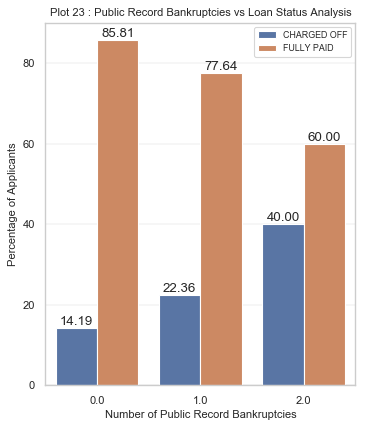

In [131]:
plt.figure(figsize=(5,6),dpi=80)
ax = sns.barplot(data=loan_prbc_df_pct,x='pub_rec_bankruptcies',y='Percentage of Applicants',hue='loan_status')
ax.set_title("Plot 23 : Public Record Bankruptcies vs Loan Status Analysis",fontsize = 10)
ax.tick_params(labelsize=10)
ax.set_xlabel('Number of Public Record Bankruptcies',fontsize = 10)
ax.set_ylabel('Percentage of Applicants',fontsize = 10)
ax.legend(loc='upper right', frameon=True,fontsize=8)
create_label(ax,'float')
plt.show()

There is a strong relation between public record bankruptcies and loan status. Since higher the number of bankruptcies higher is the likelihood of loan being charged-off.

** 13. Loan Grade vs DTI Analysis **

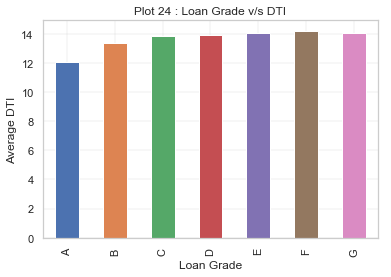

In [132]:
loan_status_df.groupby('grade')['dti'].mean().plot(kind='bar')
plt.title('Plot 24 : Loan Grade v/s DTI')
plt.ylabel('Average DTI')
plt.xlabel('Loan Grade')
plt.show()

It can be observed that loan grades are higher for loan applicant with high average dti value.

** Bivariate Analysis - Correlation **

In [133]:
loan_status_df.corr()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,pub_rec_bankruptcies
id,1.000000,0.993529,0.120403,0.131078,0.231355,0.176314,0.053692,0.075864,0.005847,0.091638,-0.008504,-0.041139,0.118934,0.016317,-0.017756,0.001628,0.090197,0.039762,0.110245,0.194603,0.092799,0.123111,-0.055864,0.038661,-0.010945,0.142139,-0.007997
member_id,0.993529,1.000000,0.120179,0.130098,0.241077,0.194833,0.050557,0.070687,0.006723,0.092763,-0.007994,-0.046001,0.124781,0.013863,-0.017140,-0.001710,0.088787,0.042074,0.111620,0.204967,0.093590,0.126502,-0.058574,0.036500,-0.012861,0.142469,-0.007346
loan_amnt,0.120403,0.120179,1.000000,0.981788,0.937921,0.346616,0.301204,0.932254,0.269119,0.062391,-0.031982,0.012913,0.015261,0.177224,-0.050022,0.314197,0.063374,0.256139,0.881901,0.847621,0.845859,0.728326,0.047087,0.142782,0.077000,0.474587,-0.035981
funded_amnt,0.131078,0.130098,0.981788,1.000000,0.956173,0.324858,0.304870,0.958031,0.264917,0.062150,-0.031896,0.012830,0.015791,0.175705,-0.050601,0.306672,0.067243,0.250510,0.898702,0.864490,0.864073,0.736638,0.049450,0.143445,0.078765,0.478421,-0.036995
funded_amnt_inv,0.231355,0.241077,0.937921,0.956173,1.000000,0.343882,0.297387,0.905460,0.252147,0.070585,-0.038213,-0.002849,0.073094,0.162789,-0.051505,0.286500,0.072045,0.242675,0.874726,0.909114,0.838582,0.726720,0.029357,0.130990,0.064276,0.469135,-0.041193
term,0.176314,0.194833,0.346616,0.324858,0.343882,1.000000,0.440179,0.090407,0.043926,0.076150,0.007253,0.047689,0.038520,0.046176,0.010253,0.066485,0.065777,0.096140,0.305539,0.320860,0.200186,0.506237,0.012839,0.112800,0.037356,0.270166,0.014529
int_rate,0.053692,0.050557,0.301204,0.304870,0.297387,0.440179,1.000000,0.277142,0.049009,0.110845,0.158459,0.133328,-0.054693,0.006060,0.098618,0.094334,0.467149,-0.046585,0.290605,0.284854,0.174657,0.521200,0.094305,0.128588,0.070008,0.174330,0.083027
installment,0.075864,0.070687,0.932254,0.958031,0.905460,0.090407,0.277142,1.000000,0.267959,0.051994,-0.019785,0.010988,0.000088,0.172916,-0.045730,0.309672,0.092942,0.229817,0.858482,0.817649,0.847751,0.642633,0.058372,0.121456,0.077514,0.413558,-0.033361
annual_inc,0.005847,0.006723,0.269119,0.264917,0.252147,0.043926,0.049009,0.267959,1.000000,-0.121458,0.022260,0.035517,-0.007197,0.156873,-0.017842,0.277241,0.016853,0.234585,0.256420,0.245346,0.256947,0.185149,0.006833,0.022199,0.015991,0.143314,-0.016224
dti,0.091638,0.092763,0.062391,0.062150,0.070585,0.076150,0.110845,0.051994,-0.121458,1.000000,-0.033369,0.002112,0.068369,0.287975,-0.004758,0.228331,0.278893,0.229164,0.059232,0.066206,0.036718,0.103060,-0.011425,0.026155,0.011739,0.008526,0.005966


In [134]:
loan_status_df.corr()['int_rate']

id                         0.053692
member_id                  0.050557
loan_amnt                  0.301204
funded_amnt                0.304870
funded_amnt_inv            0.297387
term                       0.440179
int_rate                   1.000000
installment                0.277142
annual_inc                 0.049009
dti                        0.110845
delinq_2yrs                0.158459
inq_last_6mths             0.133328
mths_since_last_delinq    -0.054693
open_acc                   0.006060
pub_rec                    0.098618
revol_bal                  0.094334
revol_util                 0.467149
total_acc                 -0.046585
total_pymnt                0.290605
total_pymnt_inv            0.284854
total_rec_prncp            0.174657
total_rec_int              0.521200
total_rec_late_fee         0.094305
recoveries                 0.128588
collection_recovery_fee    0.070008
last_pymnt_amnt            0.174330
pub_rec_bankruptcies       0.083027
Name: int_rate, dtype: float

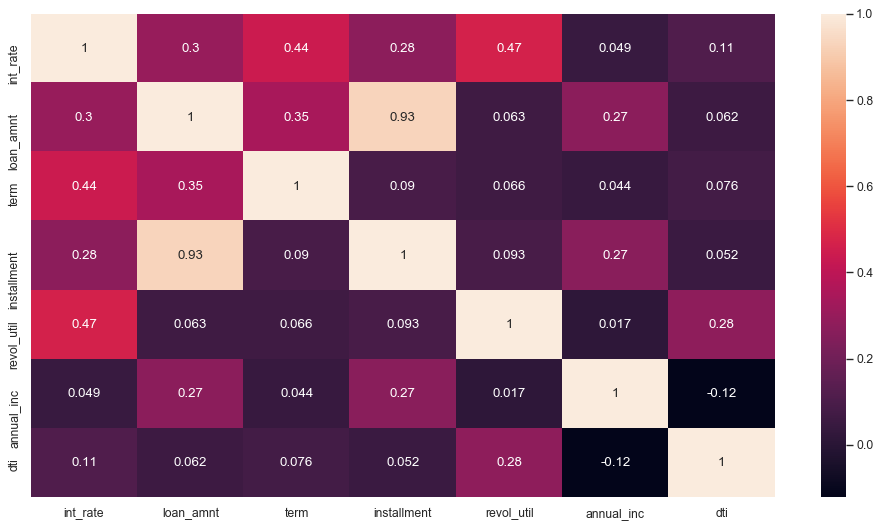

In [135]:
plt.figure(figsize=(15,8),dpi=80)
df = loan_status_df.loc[:,['int_rate','loan_amnt','term','installment','revol_util','annual_inc','dti']].corr()
sns.heatmap(data=df,annot=True)
plt.show()

Their is strong correlation between loan_amnt and installment. Also moderate correlation between interest rate-revol_util and loan_amnt-term exists.

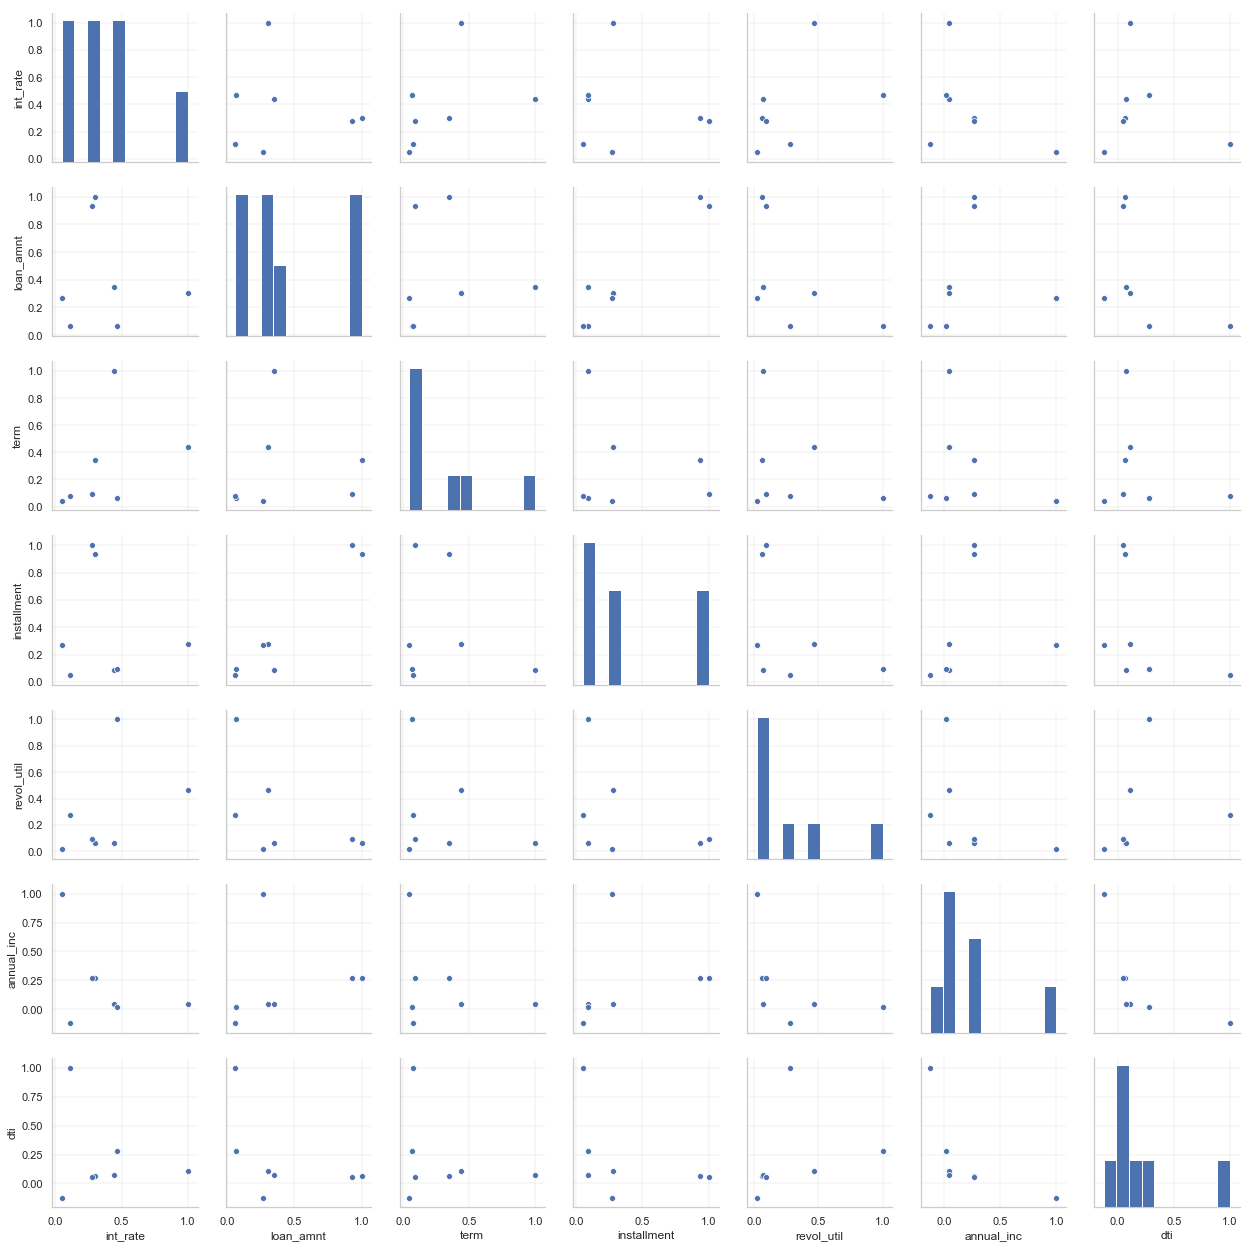

In [136]:
sns.pairplot(df)
plt.show()

# Conclusion of EDA:

We have done EDA on the loan data. Data Quality issues(missing value, has been addressed and outliers we removed accordingly during analysis.Derived metrics has been created for annual income, interest rate,revolving balance etc. for analysis.<br>

Based on EDA analysis, following variables can be said to be influencing the loan status to large extent and are drivers for loan default :

- Loan Purpose
- Loan Term
- Home Ownership
- Loan Grade
- Verification Status
- Public Bankrptcy records
- Interest Rate
- Employment Term
- Applicant's Annual Income Range